In [1]:
from train import *

c:\Users\11709\anaconda3\python.exe


Define arguments

In [5]:
def init_args() -> ARGUMENTS:
    args = ARGUMENTS(
        model_type="FASHION_VGG3",
        normal_class=1,
        num_ref=10,
        num_ref_eval=5,
        lr=1e-4,
        vector_size=2048,
        weight_decay=0.001, #done
        seed=1001,
        weight_init_seed=1001,
        alpha=0.1, # done
        k=1,
        epochs=10,
        contamination=0, # done
        batch_size=1,
        biases=1,
        dataset='cifar10'
    )
    return args
args = init_args()

Do light experiment

In [4]:
args = init_args()
args.dataset="fashion"
args.normal_class=0
args.contamination=0.1
args.k = 3
df, auc, f1, precision, recall, acc = train(args, 60)

c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 1930.8374641418457
Starting epoch 2
Epoch: 2, Train loss: 366.34478359222413
Starting epoch 3
Epoch: 3, Train loss: 265.3888279914856
Starting epoch 4
Epoch: 4, Train loss: 154.43313732147217
Starting epoch 5
Epoch: 5, Train loss: 39.16967825889587
Starting epoch 6
Epoch: 6, Train loss: 54.51185188293457
Starting epoch 7
Epoch: 7, Train loss: 28.942065048217774
Starting epoch 8
Epoch: 8, Train loss: 20.05945348739624
Starting epoch 9
Epoch: 9, Train loss: 12.845881509780884
Starting epoch 10
Epoch: 10, Train loss: 11.852552604675292
--- 4.076584815979004 seconds ---
Normal class: 0
AUC: 0.7946428571428572
F1: 0.9454545454545454
Balanced accuracy: 0.7142857142857143
recall(the proportion of actual anomaly that are correctly identified): 0.9285714285714286
specificity(the proportion of actual normal that are correctly identified): 0.5
auc: 0.8080357142857142, f1: 0.9454545454545454, spec: 0.5, recall: 0.9285714285714286, acc: 0.7142857142857143


## Find the best hyperparameters

Do experiment along class

In [7]:
results = {}
results['df'], results['auc'], results['f1'], results['spec'], results['recall'], results['acc'] = [], [], [], [], [], []
class_range = range(10)
for normal_class in class_range:
    args.normal_class = normal_class
    df, auc, f1, spec, recall, acc = train(args)
    results['df'].append(df)
    results['auc'].append(auc)
    results['f1'].append(f1)
    results['spec'].append(spec)
    results['recall'].append(recall)
    results['acc'].append(acc)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 35.96475697755814
Starting epoch 2
Epoch: 2, Train loss: 1.8295366989448667
Starting epoch 3
Epoch: 3, Train loss: 1.7032882899045945
Starting epoch 4
Epoch: 4, Train loss: 1.2225817559286951
Starting epoch 5
Epoch: 5, Train loss: 1.8677222825586797
Starting epoch 6
Epoch: 6, Train loss: 0.9718628454953432
Starting epoch 7
Epoch: 7, Train loss: 0.8472305135801435
Starting epoch 8
Epoch: 8, Train loss: 0.7453105939552188
Starting epoch 9
Epoch: 9, Train loss: 0.3671150440350175
Starting epoch 10
Epoch: 10, Train loss: 0.5738020118325948
--- 4.7518134117126465 seconds ---
Normal class: 0
AUC: 0.7853367777777777
F1: 0.9354444444444444
Balanced accuracy: 0.6772222222222222
recall(the proportion of actual anomaly that are correctly identified): 0.9354444444444444
specificity(the proportion of actual normal that are correctly identified): 0.419
Average loss: 0.07591667009913106
auc: 0.6003261111111111, f1: 0.9354444444444444, spec: 0.419, recall: 0.9354

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 38.096331395208836
Starting epoch 2
Epoch: 2, Train loss: 1.3165549524128437
Starting epoch 3
Epoch: 3, Train loss: 1.1121575826313346
Starting epoch 4
Epoch: 4, Train loss: 0.7561174453236162
Starting epoch 5
Epoch: 5, Train loss: 1.2201661529950798
Starting epoch 6
Epoch: 6, Train loss: 0.8428519236855209
Starting epoch 7
Epoch: 7, Train loss: 0.7608464163728058
Starting epoch 8
Epoch: 8, Train loss: 0.8405998267699033
Starting epoch 9
Epoch: 9, Train loss: 0.3574647625442594
Starting epoch 10
Epoch: 10, Train loss: 0.7218562387861311
--- 4.551158666610718 seconds ---
Normal class: 1
AUC: 0.9743651111111111
F1: 0.9746666666666667
Balanced accuracy: 0.8733333333333333
recall(the proportion of actual anomaly that are correctly identified): 0.9746666666666667
specificity(the proportion of actual normal that are correctly identified): 0.772
Average loss: 0.11308517918684478
auc: 0.9569196666666666, f1: 0.9746666666666667, spec: 0.772, recall: 0.9746

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 44.31218730807304
Starting epoch 2
Epoch: 2, Train loss: 1.7887403858825563
Starting epoch 3
Epoch: 3, Train loss: 1.1742852056398987
Starting epoch 4
Epoch: 4, Train loss: 0.7852212125435472
Starting epoch 5
Epoch: 5, Train loss: 1.2687142254784702
Starting epoch 6
Epoch: 6, Train loss: 0.8986601958051323
Starting epoch 7
Epoch: 7, Train loss: 0.7630331669002771
Starting epoch 8
Epoch: 8, Train loss: 0.7951855620369315
Starting epoch 9
Epoch: 9, Train loss: 0.3468511264771223
Starting epoch 10
Epoch: 10, Train loss: 0.6281776616349817
--- 4.58485746383667 seconds ---
Normal class: 2
AUC: 0.791504611111111
F1: 0.9207777777777778
Balanced accuracy: 0.6038888888888889
recall(the proportion of actual anomaly that are correctly identified): 0.9207777777777778
specificity(the proportion of actual normal that are correctly identified): 0.287
Average loss: 0.11448004626842778
auc: 0.7128096666666666, f1: 0.9207777777777778, spec: 0.287, recall: 0.9207777

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 39.22399218380451
Starting epoch 2
Epoch: 2, Train loss: 1.5049743589945137
Starting epoch 3
Epoch: 3, Train loss: 1.2008674994111062
Starting epoch 4
Epoch: 4, Train loss: 0.795260304864496
Starting epoch 5
Epoch: 5, Train loss: 1.3471704859752207
Starting epoch 6
Epoch: 6, Train loss: 0.8984314463101327
Starting epoch 7
Epoch: 7, Train loss: 0.7324356398545205
Starting epoch 8
Epoch: 8, Train loss: 0.822898922371678
Starting epoch 9
Epoch: 9, Train loss: 0.34193062921985984
Starting epoch 10
Epoch: 10, Train loss: 0.6332437288947403
--- 4.526703834533691 seconds ---
Normal class: 3
AUC: 0.8778970000000001
F1: 0.9447777777777778
Balanced accuracy: 0.7238888888888889
recall(the proportion of actual anomaly that are correctly identified): 0.9447777777777778
specificity(the proportion of actual normal that are correctly identified): 0.503
Average loss: 0.11497659450537706
auc: 0.8230455555555556, f1: 0.9447777777777778, spec: 0.503, recall: 0.944777

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 39.015690171718596
Starting epoch 2
Epoch: 2, Train loss: 1.5970436382107436
Starting epoch 3
Epoch: 3, Train loss: 1.2103541957214474
Starting epoch 4
Epoch: 4, Train loss: 0.869805253110826
Starting epoch 5
Epoch: 5, Train loss: 1.4286577283404767
Starting epoch 6
Epoch: 6, Train loss: 0.9399799558334052
Starting epoch 7
Epoch: 7, Train loss: 0.827619516197592
Starting epoch 8
Epoch: 8, Train loss: 0.8911287657916546
Starting epoch 9
Epoch: 9, Train loss: 0.37289659297093747
Starting epoch 10
Epoch: 10, Train loss: 0.6578477093018591
--- 4.640221118927002 seconds ---
Normal class: 4
AUC: 0.702518
F1: 0.9147777777777778
Balanced accuracy: 0.5738888888888889
recall(the proportion of actual anomaly that are correctly identified): 0.9147777777777778
specificity(the proportion of actual normal that are correctly identified): 0.233
Average loss: 0.12564227460394692
auc: 0.7212405555555554, f1: 0.9147777777777778, spec: 0.233, recall: 0.914777777777777

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 24.55755959749222
Starting epoch 2
Epoch: 2, Train loss: 2.081247568130493
Starting epoch 3
Epoch: 3, Train loss: 2.079451951384544
Starting epoch 4
Epoch: 4, Train loss: 1.4584134861826896
Starting epoch 5
Epoch: 5, Train loss: 1.9029951941221952
Starting epoch 6
Epoch: 6, Train loss: 0.947266610711813
Starting epoch 7
Epoch: 7, Train loss: 0.6942707877606153
Starting epoch 8
Epoch: 8, Train loss: 0.5072824977338314
Starting epoch 9
Epoch: 9, Train loss: 0.3229168005287647
Starting epoch 10
Epoch: 10, Train loss: 0.3443004634231329
--- 4.52495813369751 seconds ---
Normal class: 5
AUC: 0.7107625555555555
F1: 0.9211111111111111
Balanced accuracy: 0.6055555555555555
recall(the proportion of actual anomaly that are correctly identified): 0.9211111111111111
specificity(the proportion of actual normal that are correctly identified): 0.29
Average loss: 0.05996887831374333
auc: 0.6387722222222222, f1: 0.9211111111111111, spec: 0.29, recall: 0.92111111111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 34.74129121005535
Starting epoch 2
Epoch: 2, Train loss: 1.5676826406270266
Starting epoch 3
Epoch: 3, Train loss: 1.359709470719099
Starting epoch 4
Epoch: 4, Train loss: 0.8574039293453097
Starting epoch 5
Epoch: 5, Train loss: 1.4552385730668902
Starting epoch 6
Epoch: 6, Train loss: 0.9235952869057655
Starting epoch 7
Epoch: 7, Train loss: 0.8968251721933485
Starting epoch 8
Epoch: 8, Train loss: 0.9063701537437737
Starting epoch 9
Epoch: 9, Train loss: 0.36529837725684045
Starting epoch 10
Epoch: 10, Train loss: 0.7189970606006681
--- 4.534952878952026 seconds ---
Normal class: 6
AUC: 0.7244404444444444
F1: 0.9143333333333333
Balanced accuracy: 0.5716666666666667
recall(the proportion of actual anomaly that are correctly identified): 0.9143333333333333
specificity(the proportion of actual normal that are correctly identified): 0.229
Average loss: 0.13720699574842976
auc: 0.6089382222222222, f1: 0.9143333333333333, spec: 0.229, recall: 0.91433

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 30.507091036438943
Starting epoch 2
Epoch: 2, Train loss: 1.742357791773975
Starting epoch 3
Epoch: 3, Train loss: 1.5854419764131307
Starting epoch 4
Epoch: 4, Train loss: 1.128125856257975
Starting epoch 5
Epoch: 5, Train loss: 1.7874060811474919
Starting epoch 6
Epoch: 6, Train loss: 1.1592453164979815
Starting epoch 7
Epoch: 7, Train loss: 1.0966851521283387
Starting epoch 8
Epoch: 8, Train loss: 1.084095983952284
Starting epoch 9
Epoch: 9, Train loss: 0.46709252502769233
Starting epoch 10
Epoch: 10, Train loss: 0.8990135649219155
--- 4.530652284622192 seconds ---
Normal class: 7
AUC: 0.9485007777777777
F1: 0.9627777777777777
Balanced accuracy: 0.8138888888888889
recall(the proportion of actual anomaly that are correctly identified): 0.9627777777777777
specificity(the proportion of actual normal that are correctly identified): 0.665
Average loss: 0.05591218267050668
auc: 0.9418505555555556, f1: 0.9627777777777777, spec: 0.665, recall: 0.962777

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 38.61749374568463
Starting epoch 2
Epoch: 2, Train loss: 1.855020815692842
Starting epoch 3
Epoch: 3, Train loss: 1.4368724817410112
Starting epoch 4
Epoch: 4, Train loss: 1.0727878510951996
Starting epoch 5
Epoch: 5, Train loss: 1.7119679801166057
Starting epoch 6
Epoch: 6, Train loss: 1.103969357907772
Starting epoch 7
Epoch: 7, Train loss: 1.0114160927012563
Starting epoch 8
Epoch: 8, Train loss: 1.049199012760073
Starting epoch 9
Epoch: 9, Train loss: 0.48633739706128837
Starting epoch 10
Epoch: 10, Train loss: 0.8774597620591521
--- 4.668205976486206 seconds ---
Normal class: 8
AUC: 0.6965198333333333
F1: 0.9188888888888889
Balanced accuracy: 0.5944444444444444
recall(the proportion of actual anomaly that are correctly identified): 0.9188888888888889
specificity(the proportion of actual normal that are correctly identified): 0.27
Average loss: 0.13836560514270663
auc: 0.6611630555555555, f1: 0.9188888888888889, spec: 0.27, recall: 0.918888888

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 39.98432352095843
Starting epoch 2
Epoch: 2, Train loss: 1.3346444305032492
Starting epoch 3
Epoch: 3, Train loss: 1.0973976830486207
Starting epoch 4
Epoch: 4, Train loss: 0.7800805176608264
Starting epoch 5
Epoch: 5, Train loss: 1.2489010474644602
Starting epoch 6
Epoch: 6, Train loss: 0.8823821905069054
Starting epoch 7
Epoch: 7, Train loss: 0.799407412763685
Starting epoch 8
Epoch: 8, Train loss: 0.8015875291079283
Starting epoch 9
Epoch: 9, Train loss: 0.3527949802577496
Starting epoch 10
Epoch: 10, Train loss: 0.7124071085825563
--- 4.486351013183594 seconds ---
Normal class: 9
AUC: 0.947930111111111
F1: 0.975
Balanced accuracy: 0.875
recall(the proportion of actual anomaly that are correctly identified): 0.975
specificity(the proportion of actual normal that are correctly identified): 0.775
Average loss: 0.1224004769587651
auc: 0.9313003333333334, f1: 0.975, spec: 0.775, recall: 0.975, acc: 0.875


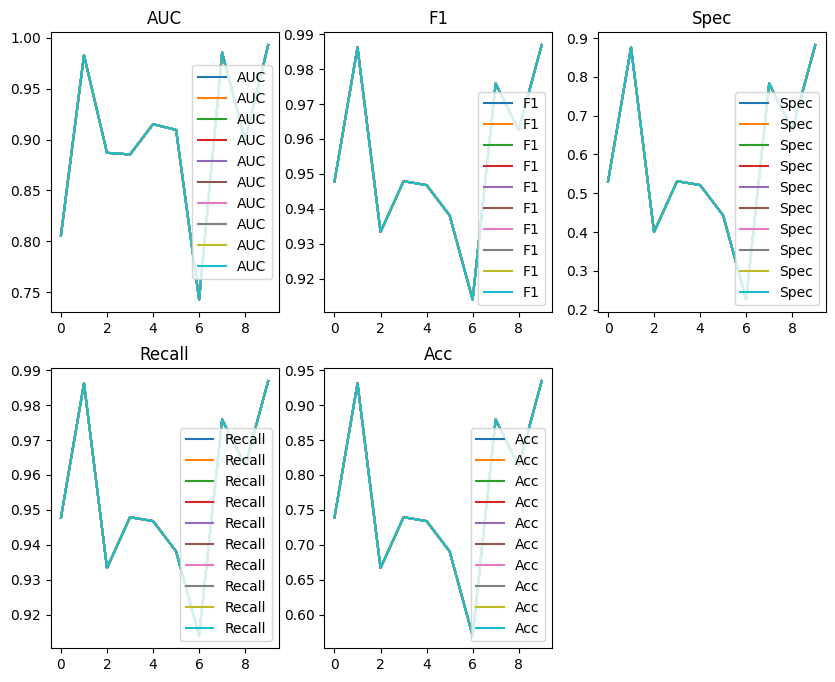

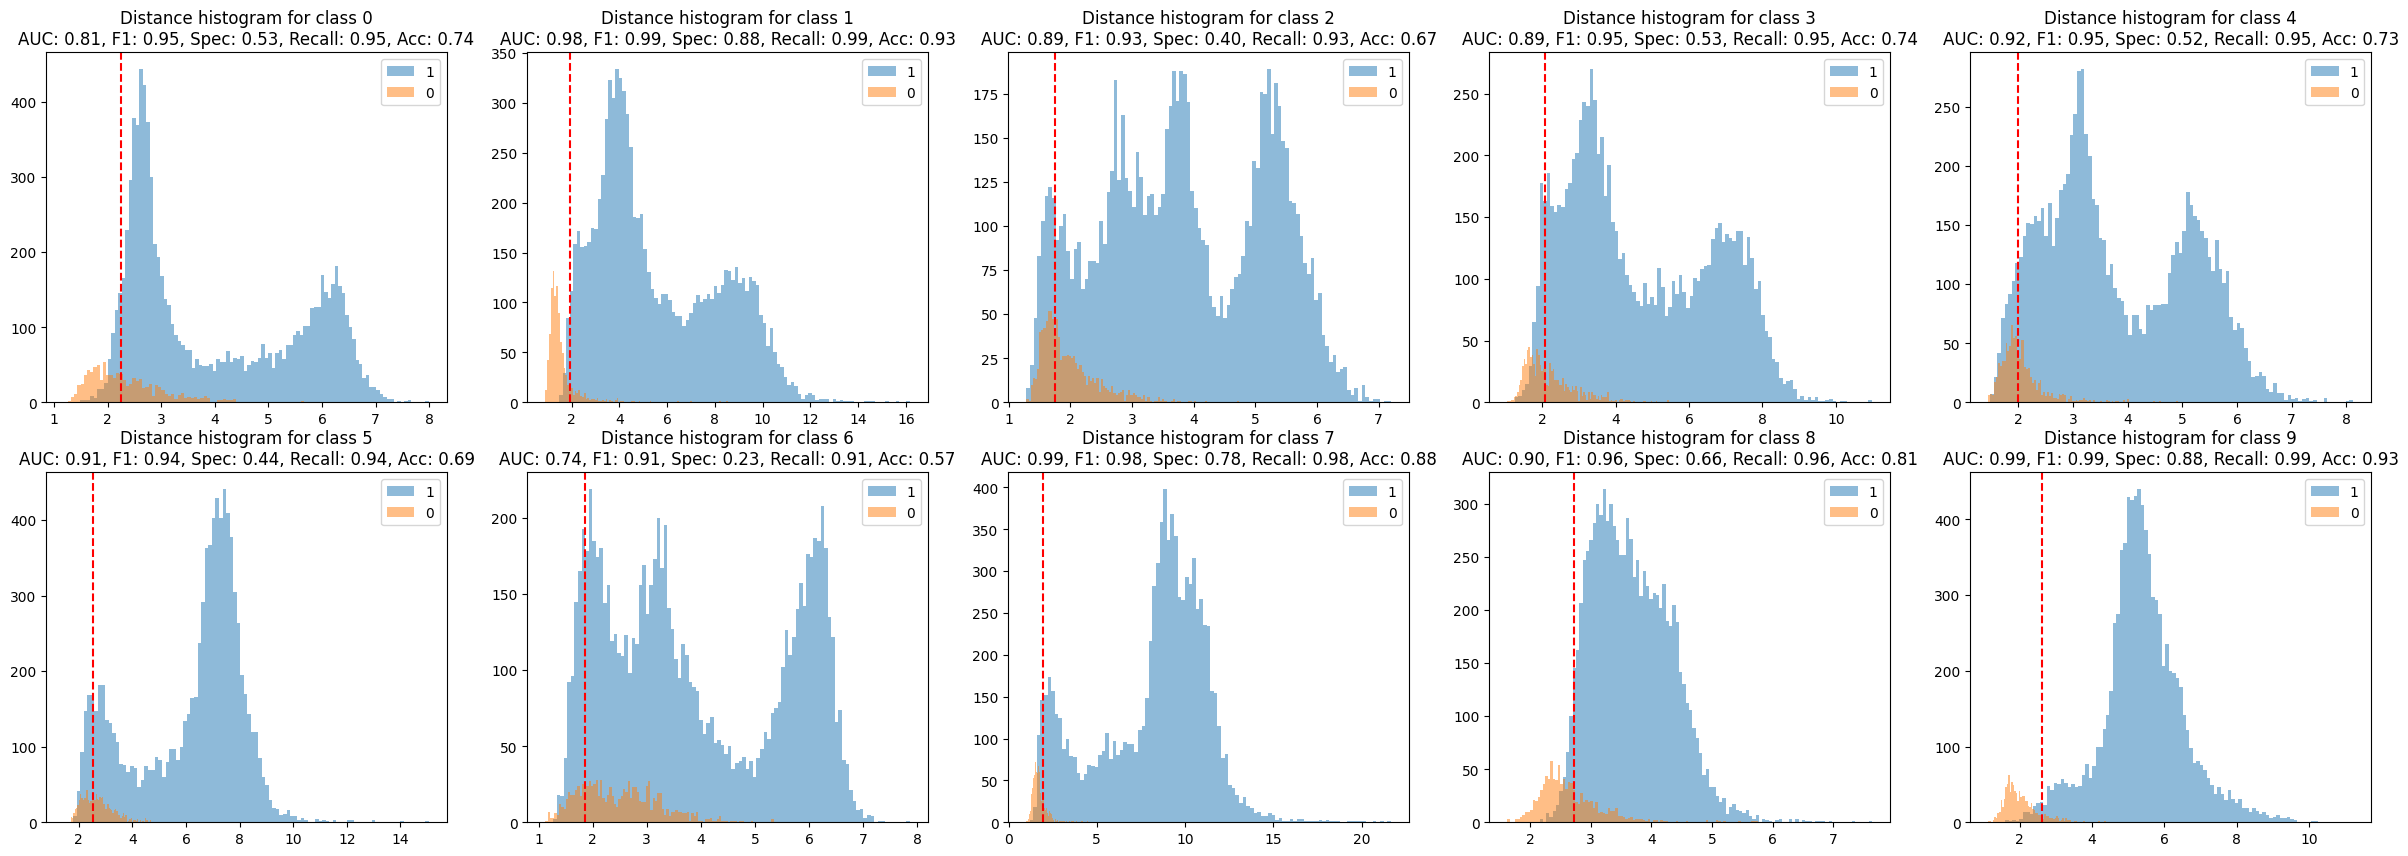

In [5]:
# Analyze result
# plot auc, f1, spec, recall, acc along normal class
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 1)
for normal_class in class_range:
    plt.plot(class_range, results['auc'], label="AUC")
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
for normal_class in class_range:
    plt.plot(class_range, results['f1'], label="F1")
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
for normal_class in class_range:
    plt.plot(class_range, results['spec'], label="Spec")
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
for normal_class in class_range:
    plt.plot(class_range, results['recall'], label="Recall")
plt.legend()
plt.title("Recall")
plt.subplot(2, 3, 5)
for normal_class in class_range:
    plt.plot(class_range, results['acc'], label="Acc")
plt.legend()
plt.title("Acc")
plt.show()

# plot the histogram for each normal class
plt.figure(figsize=(30, 10))
for normal_class in class_range:
    plt.subplot(2, 5, normal_class+1)
    thres = np.percentile(results['df'][normal_class]["minimum_dists"], 10)
    for label in results['df'][normal_class]["label"].unique():
        plt.hist(results['df'][normal_class][results['df'][normal_class]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.legend()
    plt.title(f"Distance histogram for class {normal_class}\nAUC: {results['auc'][normal_class]:.2f}, F1: {results['f1'][normal_class]:.2f}, Spec: {results['spec'][normal_class]:.2f}, Recall: {results['recall'][normal_class]:.2f}, Acc: {results['acc'][normal_class]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")
plt.show()

Do experiment along epochs

In [6]:
args = init_args()
args.normal_class = 0
result_epochs = {}

result_epochs['df'], result_epochs['auc'], result_epochs['f1'], result_epochs['spec'], result_epochs['recall'], result_epochs['acc'], result_epochs['dataset'] = [], [], [], [], [], [], []
epochs_range = np.arange(5, 15, 1)
for i, epochs in enumerate(epochs_range):
    args.epochs = epochs
    df, auc, f1, spec, recall, acc = train(args, 50)
    result_epochs['df'].append(df)
    result_epochs['auc'].append(auc)
    result_epochs['f1'].append(f1)
    result_epochs['spec'].append(spec)
    result_epochs['recall'].append(recall)
    result_epochs['acc'].append(acc)

Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/
Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/


c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/
Starting epoch 1
Epoch: 1, Train loss: 11.788100004196167
Starting epoch 2
Epoch: 2, Train loss: 1.6311730682849883
Starting epoch 3
Epoch: 3, Train loss: 0.27902437597513197
Starting epoch 4
Epoch: 4, Train loss: 0.11087787002325059
Starting epoch 5
Epoch: 5, Train loss: 0.06040771640837193
--- 1.0158905982971191 seconds ---
Normal class: 0
AUC: 0.4711111111111111
F1: 0.8888888888888888
Balanced accuracy: 0.4444444444444444
recall(the proportion of actual anomaly that are correctly identified): 0.8888888888888888
specificity(the proportion of actual normal that are correctly identified): 0.0
auc: 0.4622222222222222, f1: 0.8888888888888888, spec: 0.0, recall: 0.8888888888888888, acc: 0.4444444444444444
Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/
Using downloaded and verified file: data/cifar-10-python.tar.gz


c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/
Starting epoch 1
Epoch: 1, Train loss: 11.788099670410157
Starting epoch 2
Epoch: 2, Train loss: 1.631173348426819
Starting epoch 3
Epoch: 3, Train loss: 0.2790237575769424
Starting epoch 4
Epoch: 4, Train loss: 0.11087892539799213
Starting epoch 5
Epoch: 5, Train loss: 0.06040779054164887
Starting epoch 6
Epoch: 6, Train loss: 0.05850592628121376
--- 1.2255046367645264 seconds ---
Normal class: 0
AUC: 0.4311111111111111
F1: 0.8888888888888888
Balanced accuracy: 0.4444444444444444
recall(the proportion of actual anomaly that are correctly identified): 0.8888888888888888
specificity(the proportion of actual normal that are correctly identified): 0.0
auc: 0.44000000000000006, f1: 0.8888888888888888, spec: 0.0, recall: 0.8888888888888888, acc: 0.4444444444444444
Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/
Using 

c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\11709\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

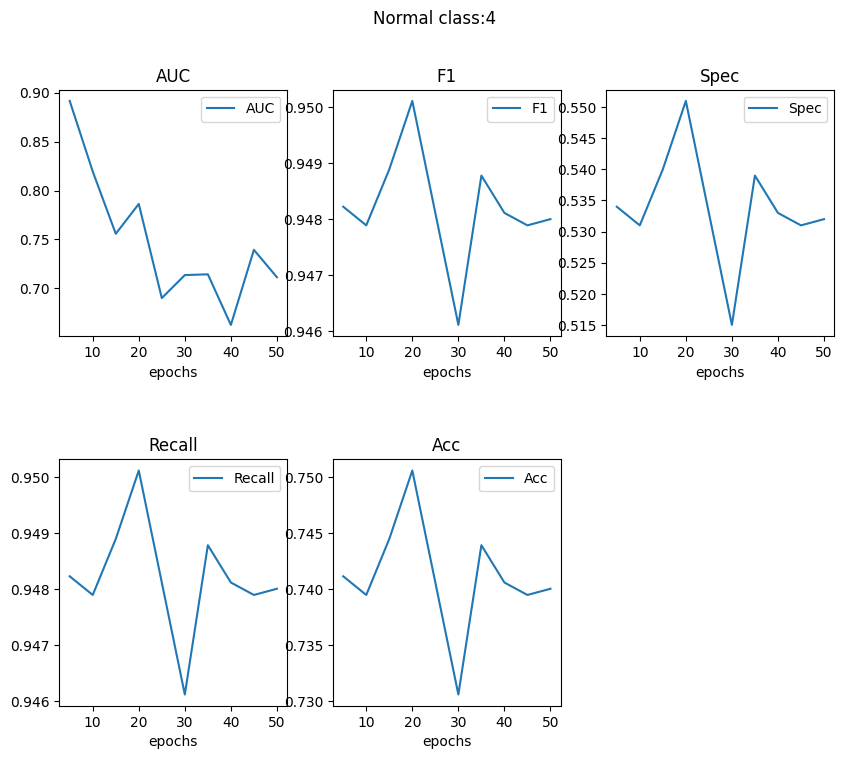

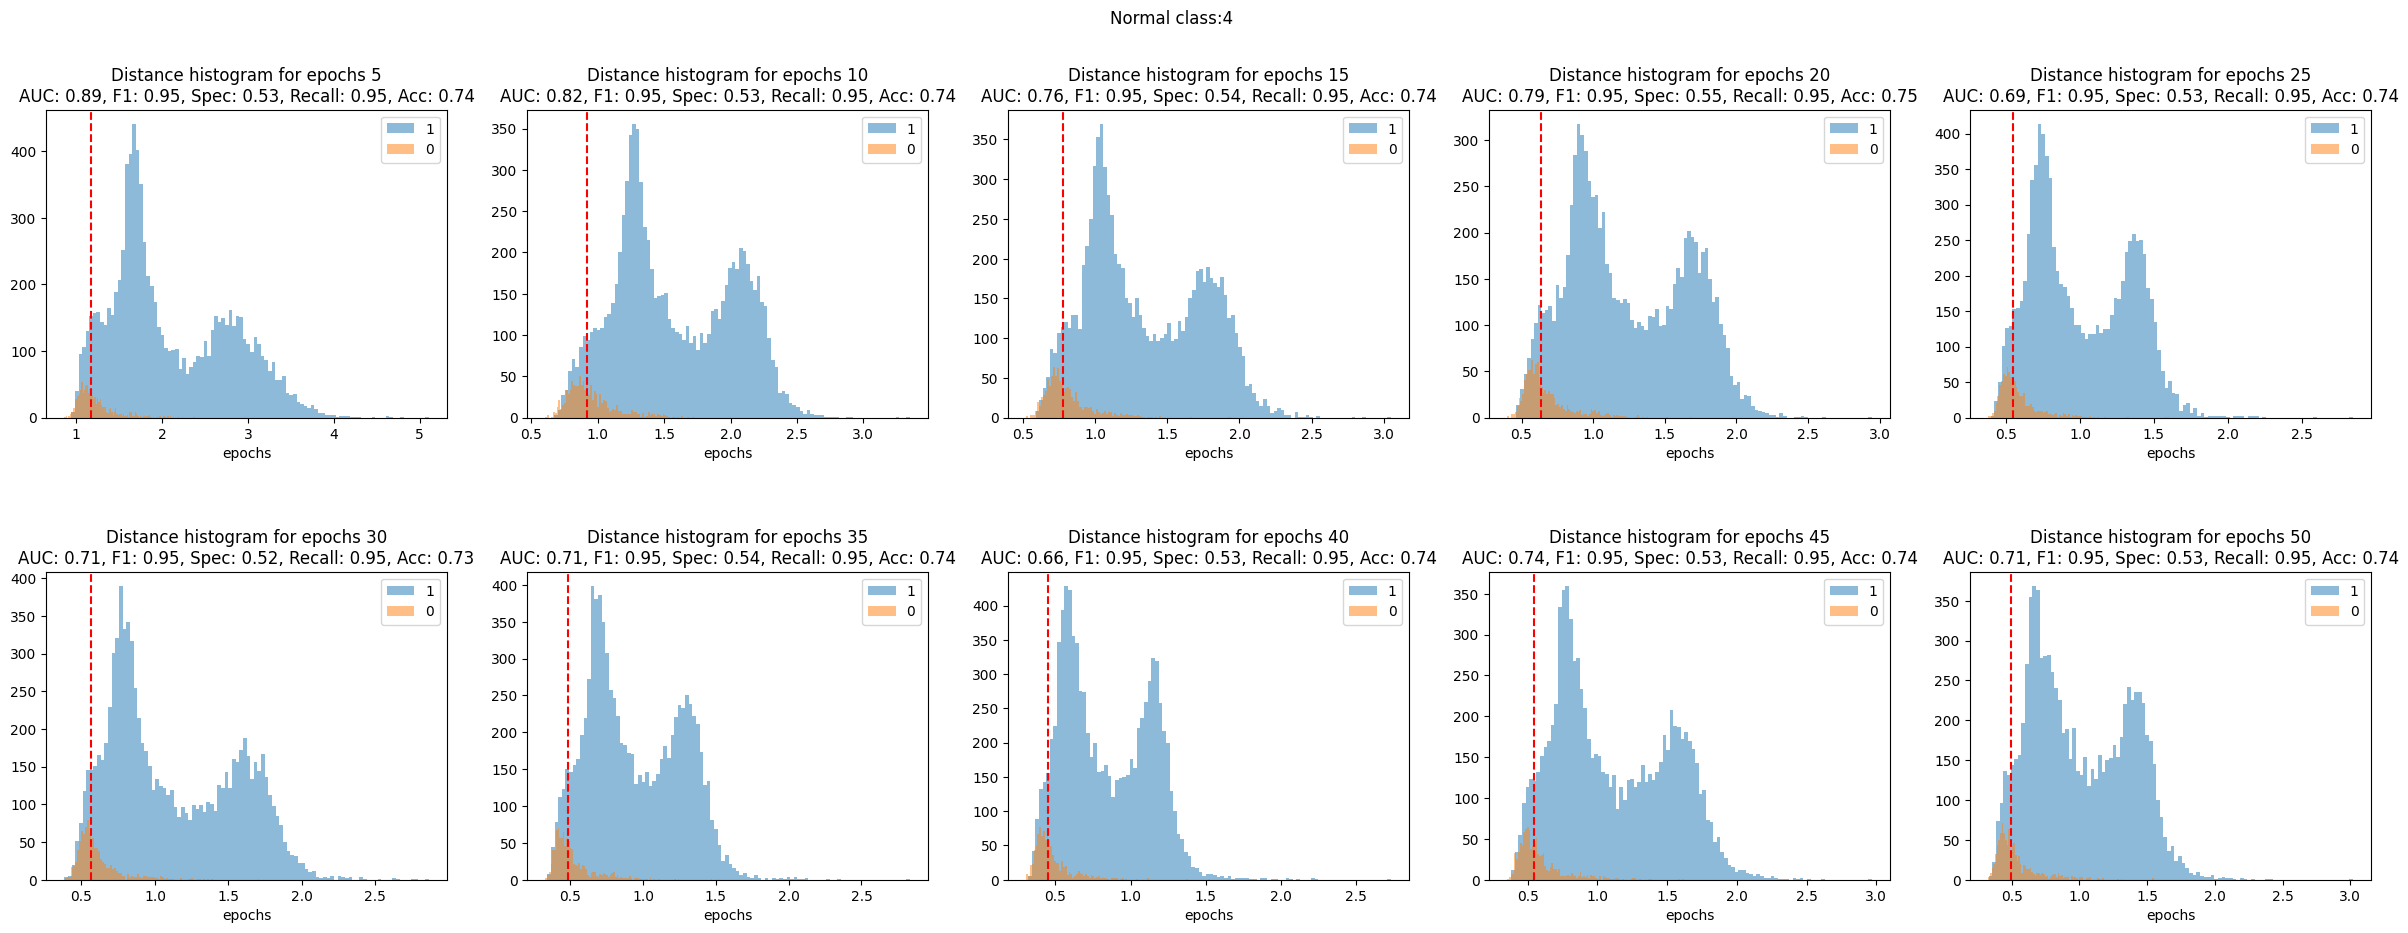

In [10]:
# Analyze result
# plot auc, f1, spec, recall, acc along epochs
plt.figure(figsize=(10, 8))
plt.suptitle(f'Normal class:{args.normal_class}')
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 3, 1)
plt.plot(epochs_range, result_epochs['auc'], label="AUC")
plt.xlabel('epochs')
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
plt.plot(epochs_range, result_epochs['f1'], label="F1")
plt.xlabel('epochs')
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
plt.plot(epochs_range, result_epochs['spec'], label="Spec")
plt.xlabel('epochs')
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
plt.plot(epochs_range, result_epochs['recall'], label="Recall")
plt.xlabel('epochs')
plt.legend()
plt.title("Recall")
plt.subplot(2, 3, 5)
plt.plot(epochs_range, result_epochs['acc'], label="Acc")
plt.xlabel('epochs')
plt.legend()
plt.title("Acc")

# plot the histogram for each epochs
plt.figure(figsize=(30, 10))
plt.suptitle(f'Normal class:{args.normal_class}')
for i, epochs in enumerate(epochs_range):
    plt.subplot(2, int(np.ceil(len(epochs_range)/2)), i+1)
    plt.subplots_adjust(hspace=0.5)
    thres = np.percentile(result_epochs['df'][i]["minimum_dists"], 10)
    for label in result_epochs['df'][i]["label"].unique():
        plt.hist(result_epochs['df'][i][result_epochs['df'][i]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.legend()
    plt.title(f"Distance histogram for epochs {epochs}\nAUC: {result_epochs['auc'][i]:.2f}, F1: {result_epochs['f1'][i]:.2f}, Spec: {result_epochs['spec'][i]:.2f}, Recall: {result_epochs['recall'][i]:.2f}, Acc: {result_epochs['acc'][i]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")
    plt.xlabel('epochs')

Do experiment along alpha

In [6]:
args = init_args()
results_alpha = {}
results_alpha['df'], results_alpha['auc'], results_alpha['f1'], results_alpha['spec'], results_alpha['recall'], results_alpha['acc'] = [], [], [], [], [], []
alpha_range = np.arange(0, 1.1, 0.1)
for alpha in alpha_range:
    args.alpha = alpha
    df, auc, f1, spec, recall, acc = train(args)
    results_alpha['df'].append(df)
    results_alpha['auc'].append(auc)
    results_alpha['f1'].append(f1)
    results_alpha['spec'].append(spec)
    results_alpha['recall'].append(recall)
    results_alpha['acc'].append(acc)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 46.279993534088135
Starting epoch 2
Epoch: 2, Train loss: 9.875727081298828
Starting epoch 3
Epoch: 3, Train loss: 5.579452335834503
Starting epoch 4
Epoch: 4, Train loss: 3.44722398519516
Starting epoch 5
Epoch: 5, Train loss: 3.4797844767570494
Starting epoch 6
Epoch: 6, Train loss: 2.466756355762482
Starting epoch 7
Epoch: 7, Train loss: 1.8595054507255555
Starting epoch 8
Epoch: 8, Train loss: 1.5078708589076997
Starting epoch 9
Epoch: 9, Train loss: 1.041336077451706
Starting epoch 10
Epoch: 10, Train loss: 1.2000553250312804
--- 4.535853862762451 seconds ---
Normal class: 9
AUC: 0.9934535555555556
F1: 0.9871111111111112
Balanced accuracy: 0.9355555555555556
recall(the proportion of actual anomaly that are correctly identified): 0.9871111111111112
specificity(the proportion of actual normal that are correctly identified): 0.884
Average loss: 0.2685152093112469
auc: 0.9924436666666666, f1: 0.9871111111111112, spec: 0.884, recall: 0.98711111111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.65537271499634
Starting epoch 2
Epoch: 2, Train loss: 8.039208686351776
Starting epoch 3
Epoch: 3, Train loss: 4.541185736656189
Starting epoch 4
Epoch: 4, Train loss: 2.818663740158081
Starting epoch 5
Epoch: 5, Train loss: 2.8436060190200805
Starting epoch 6
Epoch: 6, Train loss: 2.010450226068497
Starting epoch 7
Epoch: 7, Train loss: 1.498415035009384
Starting epoch 8
Epoch: 8, Train loss: 1.2233858674764633
Starting epoch 9
Epoch: 9, Train loss: 0.8483041763305664
Starting epoch 10
Epoch: 10, Train loss: 0.9710529088973999
--- 4.412843942642212 seconds ---
Normal class: 9
AUC: 0.993565
F1: 0.9868888888888889
Balanced accuracy: 0.9344444444444444
recall(the proportion of actual anomaly that are correctly identified): 0.9868888888888889
specificity(the proportion of actual normal that are correctly identified): 0.882
Average loss: 0.22030611958086493
auc: 0.992674, f1: 0.9868888888888889, spec: 0.882, recall: 0.9868888888888889, acc: 0.93444

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 29.901512765884398
Starting epoch 2
Epoch: 2, Train loss: 6.397202491760254
Starting epoch 3
Epoch: 3, Train loss: 3.619478327035904
Starting epoch 4
Epoch: 4, Train loss: 2.2380003690719605
Starting epoch 5
Epoch: 5, Train loss: 2.2589772045612335
Starting epoch 6
Epoch: 6, Train loss: 1.5959572911262512
Starting epoch 7
Epoch: 7, Train loss: 1.1873887479305267
Starting epoch 8
Epoch: 8, Train loss: 0.978317278623581
Starting epoch 9
Epoch: 9, Train loss: 0.6746637701988221
Starting epoch 10
Epoch: 10, Train loss: 0.7762069880962372
--- 4.4789416790008545 seconds ---
Normal class: 9
AUC: 0.9935849999999999
F1: 0.9871111111111112
Balanced accuracy: 0.9355555555555556
recall(the proportion of actual anomaly that are correctly identified): 0.9871111111111112
specificity(the proportion of actual normal that are correctly identified): 0.884
Average loss: 0.17464545844256876
auc: 0.9928064444444445, f1: 0.9871111111111112, spec: 0.884, recall: 0.987111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 23.04560341835022
Starting epoch 2
Epoch: 2, Train loss: 4.928539049625397
Starting epoch 3
Epoch: 3, Train loss: 2.794551855325699
Starting epoch 4
Epoch: 4, Train loss: 1.7254965662956239
Starting epoch 5
Epoch: 5, Train loss: 1.750786167383194
Starting epoch 6
Epoch: 6, Train loss: 1.2357844591140748
Starting epoch 7
Epoch: 7, Train loss: 0.921044585108757
Starting epoch 8
Epoch: 8, Train loss: 0.7534833550453186
Starting epoch 9
Epoch: 9, Train loss: 0.5230851143598556
Starting epoch 10
Epoch: 10, Train loss: 0.6041357457637787
--- 4.556869983673096 seconds ---
Normal class: 9
AUC: 0.9936747777777778
F1: 0.9871111111111112
Balanced accuracy: 0.9355555555555556
recall(the proportion of actual anomaly that are correctly identified): 0.9871111111111112
specificity(the proportion of actual normal that are correctly identified): 0.884
Average loss: 0.13575548626422884
auc: 0.9929713333333333, f1: 0.9871111111111112, spec: 0.884, recall: 0.987111111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 17.09001507759094
Starting epoch 2
Epoch: 2, Train loss: 3.661812949180603
Starting epoch 3
Epoch: 3, Train loss: 2.0798495441675184
Starting epoch 4
Epoch: 4, Train loss: 1.2904432892799378
Starting epoch 5
Epoch: 5, Train loss: 1.3003978550434112
Starting epoch 6
Epoch: 6, Train loss: 0.9281735688447952
Starting epoch 7
Epoch: 7, Train loss: 0.6888914972543716
Starting epoch 8
Epoch: 8, Train loss: 0.5646990343928338
Starting epoch 9
Epoch: 9, Train loss: 0.39181180149316785
Starting epoch 10
Epoch: 10, Train loss: 0.44879195690155027
--- 4.622806072235107 seconds ---
Normal class: 9
AUC: 0.9936804444444445
F1: 0.9872222222222222
Balanced accuracy: 0.9361111111111111
recall(the proportion of actual anomaly that are correctly identified): 0.9872222222222222
specificity(the proportion of actual normal that are correctly identified): 0.885
Average loss: 0.10203900941181171
auc: 0.9930718888888889, f1: 0.9872222222222222, spec: 0.885, recall: 0.9872

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 12.017884612083435
Starting epoch 2
Epoch: 2, Train loss: 2.5784845769405367
Starting epoch 3
Epoch: 3, Train loss: 1.4656173974275588
Starting epoch 4
Epoch: 4, Train loss: 0.9105226308107376
Starting epoch 5
Epoch: 5, Train loss: 0.9193111300468445
Starting epoch 6
Epoch: 6, Train loss: 0.6509054243564606
Starting epoch 7
Epoch: 7, Train loss: 0.48448121547698975
Starting epoch 8
Epoch: 8, Train loss: 0.3968192473053932
Starting epoch 9
Epoch: 9, Train loss: 0.2763961747288704
Starting epoch 10
Epoch: 10, Train loss: 0.31428912878036497
--- 4.591172456741333 seconds ---
Normal class: 9
AUC: 0.993735
F1: 0.9873333333333333
Balanced accuracy: 0.9366666666666666
recall(the proportion of actual anomaly that are correctly identified): 0.9873333333333333
specificity(the proportion of actual normal that are correctly identified): 0.886
Average loss: 0.07291456893805709
auc: 0.993202888888889, f1: 0.9873333333333333, spec: 0.886, recall: 0.9873333333333

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 7.837064743041992
Starting epoch 2
Epoch: 2, Train loss: 1.6871896535158157
Starting epoch 3
Epoch: 3, Train loss: 0.9644650503993034
Starting epoch 4
Epoch: 4, Train loss: 0.5997791051864624
Starting epoch 5
Epoch: 5, Train loss: 0.6003770917654038
Starting epoch 6
Epoch: 6, Train loss: 0.4253328010439873
Starting epoch 7
Epoch: 7, Train loss: 0.3158136487007141
Starting epoch 8
Epoch: 8, Train loss: 0.25955639630556104
Starting epoch 9
Epoch: 9, Train loss: 0.18015618324279786
Starting epoch 10
Epoch: 10, Train loss: 0.2026132471859455
--- 4.604573965072632 seconds ---
Normal class: 9
AUC: 0.9937794444444444
F1: 0.9873333333333333
Balanced accuracy: 0.9366666666666666
recall(the proportion of actual anomaly that are correctly identified): 0.9873333333333333
specificity(the proportion of actual normal that are correctly identified): 0.886
Average loss: 0.04865738387808354
auc: 0.9932968888888888, f1: 0.9873333333333333, spec: 0.886, recall: 0.987

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 4.544370126724243
Starting epoch 2
Epoch: 2, Train loss: 0.9838804081082344
Starting epoch 3
Epoch: 3, Train loss: 0.5649578467011451
Starting epoch 4
Epoch: 4, Train loss: 0.3545115739107132
Starting epoch 5
Epoch: 5, Train loss: 0.35127351954579356
Starting epoch 6
Epoch: 6, Train loss: 0.248504176735878
Starting epoch 7
Epoch: 7, Train loss: 0.18647140488028527
Starting epoch 8
Epoch: 8, Train loss: 0.15264553353190422
Starting epoch 9
Epoch: 9, Train loss: 0.10616132393479347
Starting epoch 10
Epoch: 10, Train loss: 0.1171120285987854
--- 4.546725749969482 seconds ---
Normal class: 9
AUC: 0.9937813333333333
F1: 0.9874444444444445
Balanced accuracy: 0.9372222222222222
recall(the proportion of actual anomaly that are correctly identified): 0.9874444444444445
specificity(the proportion of actual normal that are correctly identified): 0.887
Average loss: 0.032413496110393916
auc: 0.9933418888888889, f1: 0.9874444444444445, spec: 0.887, recall: 0.9

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 2.1403418481349945
Starting epoch 2
Epoch: 2, Train loss: 0.4689127832651138
Starting epoch 3
Epoch: 3, Train loss: 0.27031666934490206
Starting epoch 4
Epoch: 4, Train loss: 0.1715115338563919
Starting epoch 5
Epoch: 5, Train loss: 0.16577179692685604
Starting epoch 6
Epoch: 6, Train loss: 0.12033147886395454
Starting epoch 7
Epoch: 7, Train loss: 0.08888427503407001
Starting epoch 8
Epoch: 8, Train loss: 0.07214433513581753
Starting epoch 9
Epoch: 9, Train loss: 0.05071705281734466
Starting epoch 10
Epoch: 10, Train loss: 0.053423105552792546
--- 4.54979395866394 seconds ---
Normal class: 9
AUC: 0.9937437777777777
F1: 0.9874444444444445
Balanced accuracy: 0.9372222222222222
recall(the proportion of actual anomaly that are correctly identified): 0.9874444444444445
specificity(the proportion of actual normal that are correctly identified): 0.887
Average loss: 0.05474280033381731
auc: 0.9933543333333335, f1: 0.9874444444444445, spec: 0.887, recall:

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 0.6304128050804139
Starting epoch 2
Epoch: 2, Train loss: 0.14263433925807475
Starting epoch 3
Epoch: 3, Train loss: 0.08370980769395828
Starting epoch 4
Epoch: 4, Train loss: 0.05445018112659454
Starting epoch 5
Epoch: 5, Train loss: 0.04987177681177855
Starting epoch 6
Epoch: 6, Train loss: 0.0370023088529706
Starting epoch 7
Epoch: 7, Train loss: 0.026547451689839362
Starting epoch 8
Epoch: 8, Train loss: 0.020861994847655295
Starting epoch 9
Epoch: 9, Train loss: 0.015037481766194105
Starting epoch 10
Epoch: 10, Train loss: 0.013871235027909278
--- 4.422186851501465 seconds ---
Normal class: 9
AUC: 0.9936874444444446
F1: 0.9873333333333333
Balanced accuracy: 0.9366666666666666
recall(the proportion of actual anomaly that are correctly identified): 0.9873333333333333
specificity(the proportion of actual normal that are correctly identified): 0.886
Average loss: 0.31182971649959684
auc: 0.9933045555555556, f1: 0.9873333333333333, spec: 0.886, re

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 0.021726974006792237
Starting epoch 2
Epoch: 2, Train loss: 0.00745221902621322
Starting epoch 3
Epoch: 3, Train loss: 0.003490333864515356
Starting epoch 4
Epoch: 4, Train loss: 0.0019373507006593862
Starting epoch 5
Epoch: 5, Train loss: 0.0012266934966237166
Starting epoch 6
Epoch: 6, Train loss: 0.0008439433353987403
Starting epoch 7
Epoch: 7, Train loss: 0.0006163730286561765
Starting epoch 8
Epoch: 8, Train loss: 0.0004691546201274611
Starting epoch 9
Epoch: 9, Train loss: 0.00037645089619670736
Starting epoch 10
Epoch: 10, Train loss: 0.00031143441743095143
--- 4.416656970977783 seconds ---
Normal class: 9
AUC: 0.5
F1: 0.0
Balanced accuracy: 0.5
recall(the proportion of actual anomaly that are correctly identified): 0.0
specificity(the proportion of actual normal that are correctly identified): 1.0
Average loss: 0.9377873352347699
auc: 0.5, f1: 0.0, spec: 1.0, recall: 0.0, acc: 0.5


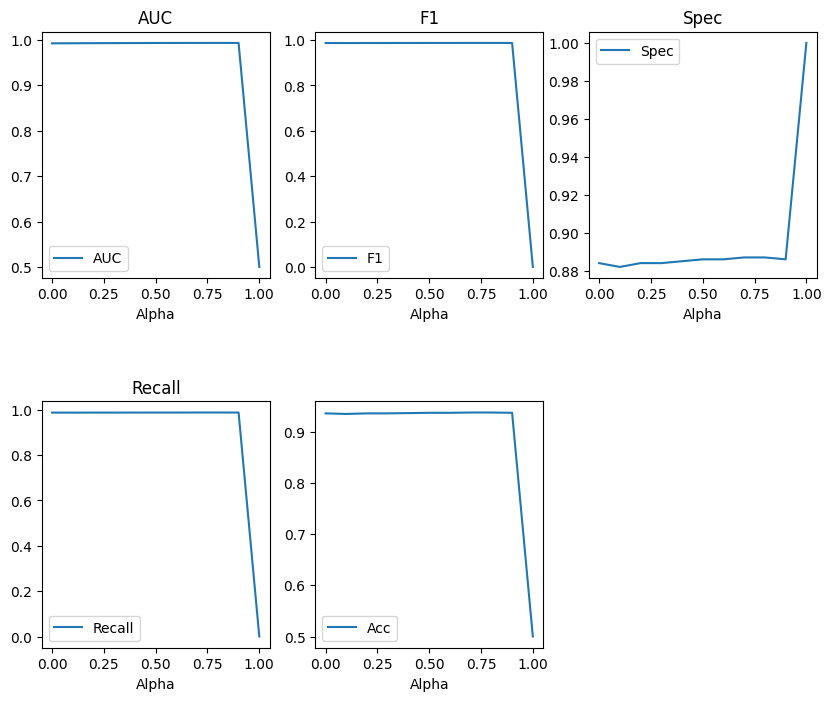

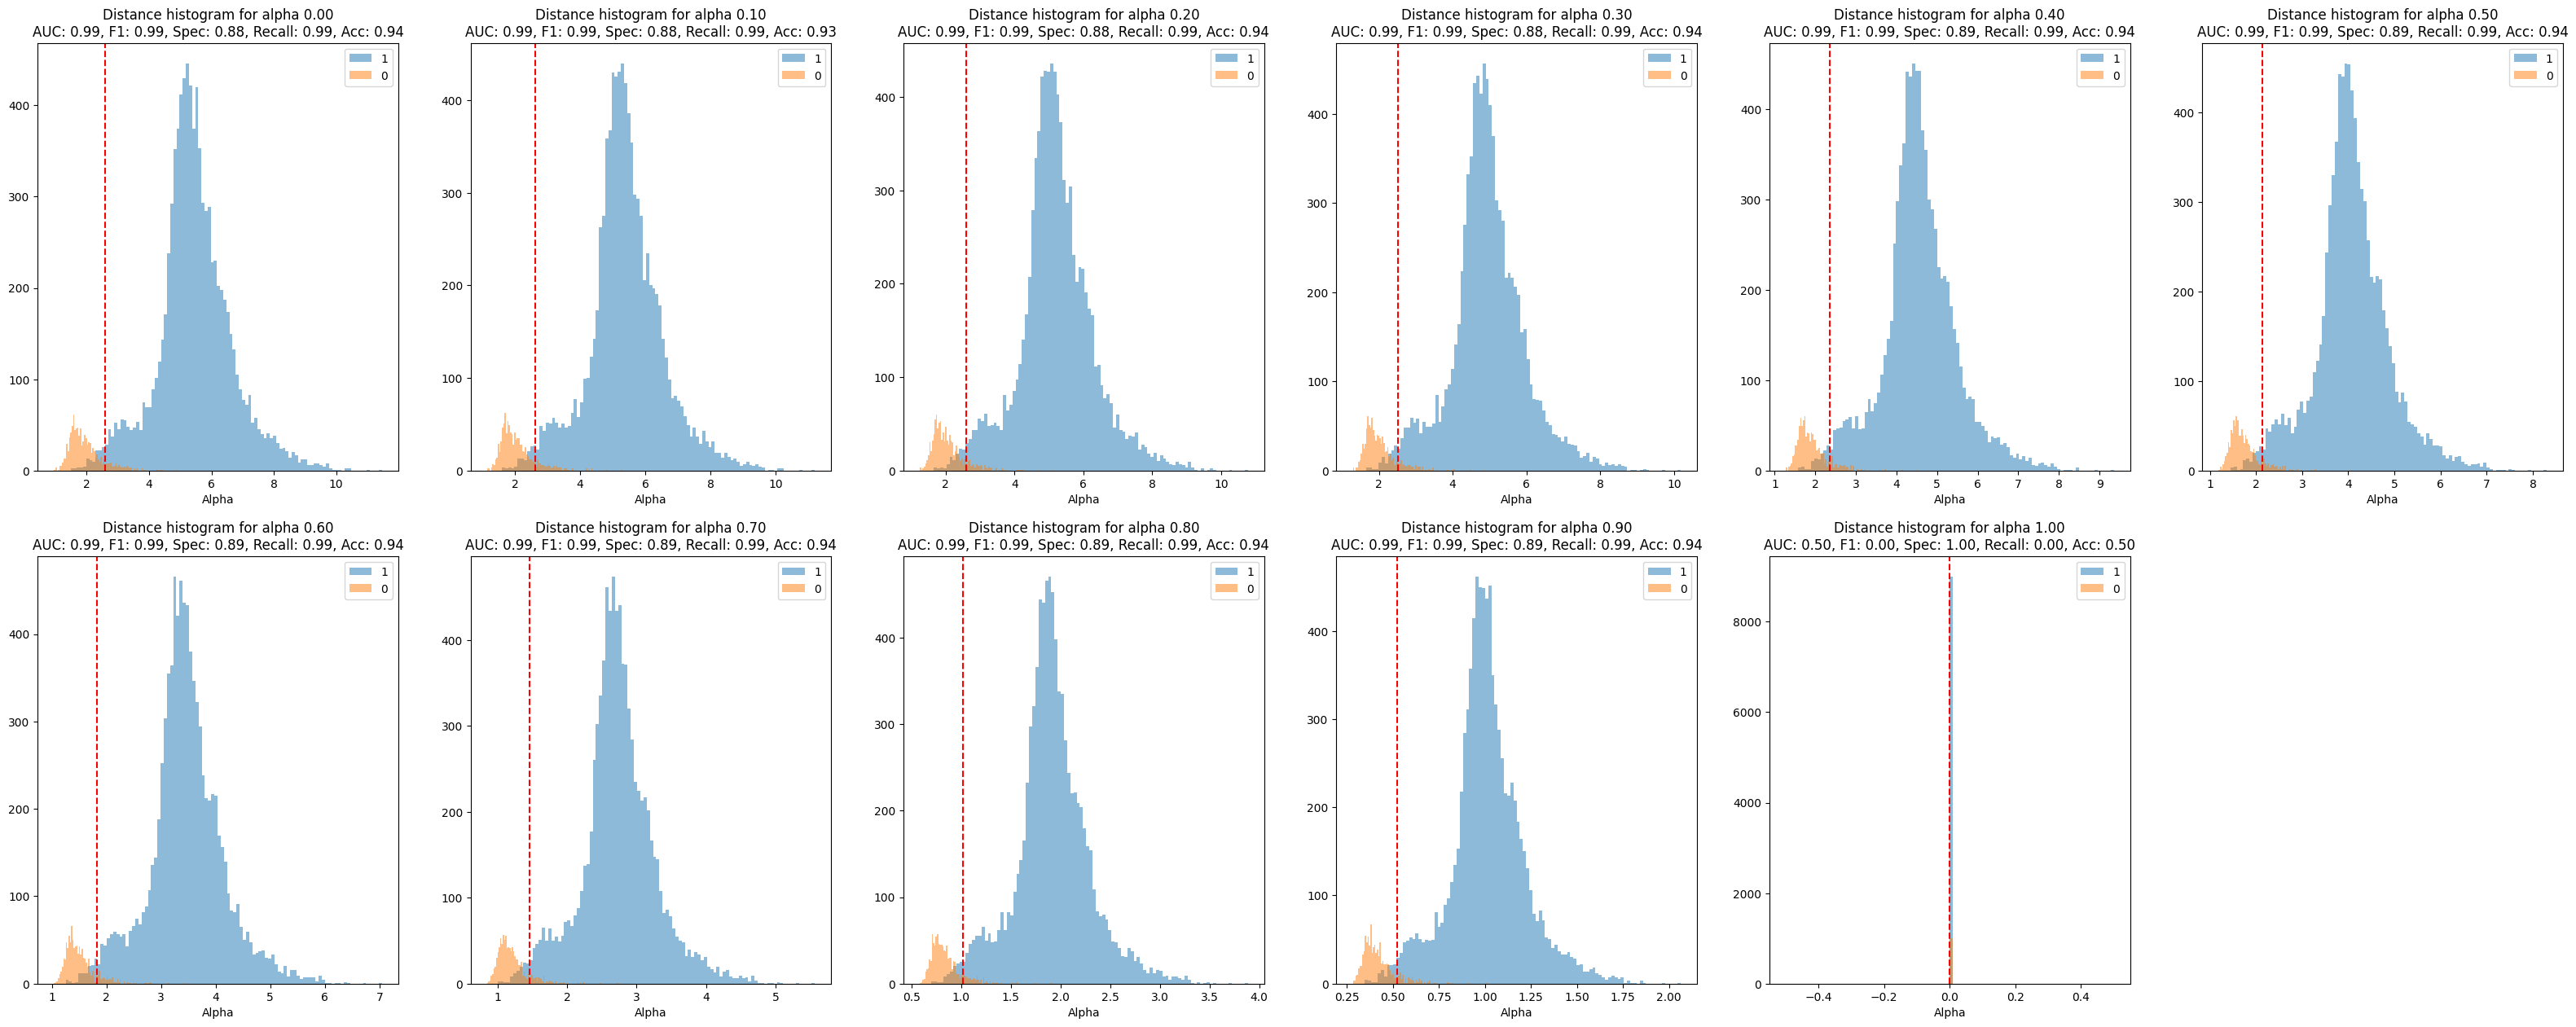

In [13]:
# Analyze result
# plot auc, f1, spec, recall, acc along alpha
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 1)
plt.plot(alpha_range, results_alpha['auc'], label="AUC")
plt.xlabel("Alpha")
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
plt.plot(alpha_range, results_alpha['f1'], label="F1")
plt.xlabel("Alpha")
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
plt.plot(alpha_range, results_alpha['spec'], label="Spec")
plt.xlabel("Alpha")
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
plt.plot(alpha_range, results_alpha['recall'], label="Recall")
plt.xlabel("Alpha")
plt.legend()
plt.title("Recall")
plt.subplot(2, 3, 5)
plt.plot(alpha_range, results_alpha['acc'], label="Acc")
plt.xlabel("Alpha")
plt.legend()

# plot the histogram for each alpha
plt.subplots_adjust(hspace=0.5)
plt.figure(figsize=(40, 15))
for i, alpha in enumerate(alpha_range):
    plt.subplot(2, 6, i+1)
    thres = np.percentile(results_alpha['df'][i]["minimum_dists"], 10)
    for label in results_alpha['df'][i]["label"].unique():
        plt.hist(results_alpha['df'][i][results_alpha['df'][i]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
        plt.xlabel('Alpha')
    plt.legend()
    plt.title(f"Distance histogram for alpha {alpha:.2f}\nAUC: {results_alpha['auc'][i]:.2f}, F1: {results_alpha['f1'][i]:.2f}, Spec: {results_alpha['spec'][i]:.2f}, Recall: {results_alpha['recall'][i]:.2f}, Acc: {results_alpha['acc'][i]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")
    

Do experiment along contamination

In [4]:
args = init_args()
args.normal_class = 6
results_contamination = {}
results_contamination['df'], results_contamination['auc'], results_contamination['f1'], results_contamination['spec'], results_contamination['recall'], results_contamination['acc'] = [], [], [], [], [], []
contamination_range = np.arange(0, 1, 0.1)
for contamination in contamination_range:
    args.contamination = contamination
    df, auc, f1, spec, recall, acc = train(args, 100)
    results_contamination['df'].append(df)
    results_contamination['auc'].append(auc)
    results_contamination['f1'].append(f1)
    results_contamination['spec'].append(spec)
    results_contamination['recall'].append(recall)
    results_contamination['acc'].append(acc)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 34.74129121005535
Starting epoch 2
Epoch: 2, Train loss: 1.5676826406270266
Starting epoch 3
Epoch: 3, Train loss: 1.359709470719099
Starting epoch 4
Epoch: 4, Train loss: 0.8574039293453097
Starting epoch 5
Epoch: 5, Train loss: 1.4552385730668902
Starting epoch 6
Epoch: 6, Train loss: 0.9235952869057655
Starting epoch 7
Epoch: 7, Train loss: 0.8968251721933485
Starting epoch 8
Epoch: 8, Train loss: 0.9063701537437737
Starting epoch 9
Epoch: 9, Train loss: 0.36529837725684045
Starting epoch 10
Epoch: 10, Train loss: 0.7189970606006681
--- 4.93370795249939 seconds ---
Normal class: 6
AUC: 0.813858695652174
F1: 0.9230769230769231
Balanced accuracy: 0.5815217391304348
recall(the proportion of actual anomaly that are correctly identified): 0.9130434782608695
specificity(the proportion of actual normal that are correctly identified): 0.25
Average loss: 0.13698977898806333
auc: 0.7595108695652173, f1: 0.9230769230769231, spec: 0.25, recall: 0.913043478

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 40.18332741260529
Starting epoch 2
Epoch: 2, Train loss: 1.8513470206409692
Starting epoch 3
Epoch: 3, Train loss: 1.4170730493031443
Starting epoch 4
Epoch: 4, Train loss: 1.0057830026373267
Starting epoch 5
Epoch: 5, Train loss: 1.524056124780327
Starting epoch 6
Epoch: 6, Train loss: 1.0554276499897242
Starting epoch 7
Epoch: 7, Train loss: 0.9138474509119987
Starting epoch 8
Epoch: 8, Train loss: 0.8330311051569879
Starting epoch 9
Epoch: 9, Train loss: 0.3375548208132386
Starting epoch 10
Epoch: 10, Train loss: 0.675355296395719
--- 4.617404937744141 seconds ---
Normal class: 6
AUC: 0.7907608695652174
F1: 0.9340659340659341
Balanced accuracy: 0.6494565217391304
recall(the proportion of actual anomaly that are correctly identified): 0.9239130434782609
specificity(the proportion of actual normal that are correctly identified): 0.375
Average loss: 0.10746642367307505
auc: 0.8192934782608696, f1: 0.9340659340659341, spec: 0.375, recall: 0.9239130

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 41.64616059213877
Starting epoch 2
Epoch: 2, Train loss: 1.9063932076096535
Starting epoch 3
Epoch: 3, Train loss: 1.4103671429678797
Starting epoch 4
Epoch: 4, Train loss: 0.9980435509234666
Starting epoch 5
Epoch: 5, Train loss: 1.48583681024611
Starting epoch 6
Epoch: 6, Train loss: 1.032741378247738
Starting epoch 7
Epoch: 7, Train loss: 0.83998315744102
Starting epoch 8
Epoch: 8, Train loss: 0.8540572449564934
Starting epoch 9
Epoch: 9, Train loss: 0.3455420421436429
Starting epoch 10
Epoch: 10, Train loss: 0.6795782813802361
--- 4.595690965652466 seconds ---
Normal class: 6
AUC: 0.7567934782608695
F1: 0.9230769230769231
Balanced accuracy: 0.5815217391304348
recall(the proportion of actual anomaly that are correctly identified): 0.9130434782608695
specificity(the proportion of actual normal that are correctly identified): 0.25
Average loss: 0.12362128964503062
auc: 0.8057065217391304, f1: 0.9230769230769231, spec: 0.25, recall: 0.913043478260

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 40.909197056293486
Starting epoch 2
Epoch: 2, Train loss: 1.8051741762086748
Starting epoch 3
Epoch: 3, Train loss: 1.4074845049530267
Starting epoch 4
Epoch: 4, Train loss: 1.0305614594370127
Starting epoch 5
Epoch: 5, Train loss: 1.539326691068709
Starting epoch 6
Epoch: 6, Train loss: 1.0122509106993676
Starting epoch 7
Epoch: 7, Train loss: 0.8250096306204796
Starting epoch 8
Epoch: 8, Train loss: 0.7542034659534693
Starting epoch 9
Epoch: 9, Train loss: 0.3152825035154819
Starting epoch 10
Epoch: 10, Train loss: 0.6047701831907034
--- 4.712363958358765 seconds ---
Normal class: 6
AUC: 0.7472826086956522
F1: 0.9230769230769231
Balanced accuracy: 0.5815217391304348
recall(the proportion of actual anomaly that are correctly identified): 0.9130434782608695
specificity(the proportion of actual normal that are correctly identified): 0.25
Average loss: 0.1256426796464166
auc: 0.7785326086956521, f1: 0.9230769230769231, spec: 0.25, recall: 0.91304347

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 40.909197056293486
Starting epoch 2
Epoch: 2, Train loss: 1.8051741762086748
Starting epoch 3
Epoch: 3, Train loss: 1.4074845049530267
Starting epoch 4
Epoch: 4, Train loss: 1.0305614594370127
Starting epoch 5
Epoch: 5, Train loss: 1.539326691068709
Starting epoch 6
Epoch: 6, Train loss: 1.0122509106993676
Starting epoch 7
Epoch: 7, Train loss: 0.8250096306204796
Starting epoch 8
Epoch: 8, Train loss: 0.7542034659534693
Starting epoch 9
Epoch: 9, Train loss: 0.3152825035154819
Starting epoch 10
Epoch: 10, Train loss: 0.6047701831907034
--- 4.6144983768463135 seconds ---
Normal class: 6
AUC: 0.7472826086956522
F1: 0.9230769230769231
Balanced accuracy: 0.5815217391304348
recall(the proportion of actual anomaly that are correctly identified): 0.9130434782608695
specificity(the proportion of actual normal that are correctly identified): 0.25
Average loss: 0.1256426796464166
auc: 0.7785326086956521, f1: 0.9230769230769231, spec: 0.25, recall: 0.9130434

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 38.72836251854896
Starting epoch 2
Epoch: 2, Train loss: 1.9806801822036504
Starting epoch 3
Epoch: 3, Train loss: 1.624274446349591
Starting epoch 4
Epoch: 4, Train loss: 1.05568327922374
Starting epoch 5
Epoch: 5, Train loss: 1.6571550546213984
Starting epoch 6
Epoch: 6, Train loss: 1.0809586160816251
Starting epoch 7
Epoch: 7, Train loss: 0.9791395954787732
Starting epoch 8
Epoch: 8, Train loss: 0.9893001828342676
Starting epoch 9
Epoch: 9, Train loss: 0.39747483655810356
Starting epoch 10
Epoch: 10, Train loss: 0.7292123013176024
--- 4.653038263320923 seconds ---
Normal class: 6
AUC: 0.7921195652173914
F1: 0.945054945054945
Balanced accuracy: 0.7173913043478262
recall(the proportion of actual anomaly that are correctly identified): 0.9347826086956522
specificity(the proportion of actual normal that are correctly identified): 0.5
Average loss: 0.1400604373749811
auc: 0.8233695652173914, f1: 0.945054945054945, spec: 0.5, recall: 0.93478260869565

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 36.56847893595695
Starting epoch 2
Epoch: 2, Train loss: 2.0882059834897517
Starting epoch 3
Epoch: 3, Train loss: 1.723368125408888
Starting epoch 4
Epoch: 4, Train loss: 1.2239607967436315
Starting epoch 5
Epoch: 5, Train loss: 1.971150860004127
Starting epoch 6
Epoch: 6, Train loss: 1.051131379418075
Starting epoch 7
Epoch: 7, Train loss: 0.8563715856522321
Starting epoch 8
Epoch: 8, Train loss: 0.8252842210233211
Starting epoch 9
Epoch: 9, Train loss: 0.3478558961302042
Starting epoch 10
Epoch: 10, Train loss: 0.542971771210432
--- 4.486823320388794 seconds ---
Normal class: 6
AUC: 0.6616847826086958
F1: 0.9120879120879121
Balanced accuracy: 0.5135869565217391
recall(the proportion of actual anomaly that are correctly identified): 0.9021739130434783
specificity(the proportion of actual normal that are correctly identified): 0.125
Average loss: 0.09425961125281174
auc: 0.6385869565217391, f1: 0.9120879120879121, spec: 0.125, recall: 0.902173913

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.33412642478943
Starting epoch 2
Epoch: 2, Train loss: 2.1644307292997835
Starting epoch 3
Epoch: 3, Train loss: 1.6176146071404218
Starting epoch 4
Epoch: 4, Train loss: 1.18465431407094
Starting epoch 5
Epoch: 5, Train loss: 1.7556758817285298
Starting epoch 6
Epoch: 6, Train loss: 1.1545429904013873
Starting epoch 7
Epoch: 7, Train loss: 0.9635114658623933
Starting epoch 8
Epoch: 8, Train loss: 0.9128776911646128
Starting epoch 9
Epoch: 9, Train loss: 0.41304021440446376
Starting epoch 10
Epoch: 10, Train loss: 0.7481426984071732
--- 4.696711778640747 seconds ---
Normal class: 6
AUC: 0.657608695652174
F1: 0.9120879120879121
Balanced accuracy: 0.5135869565217391
recall(the proportion of actual anomaly that are correctly identified): 0.9021739130434783
specificity(the proportion of actual normal that are correctly identified): 0.125
Average loss: 0.10239286939852173
auc: 0.6630434782608695, f1: 0.9120879120879121, spec: 0.125, recall: 0.9021739

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.33412642478943
Starting epoch 2
Epoch: 2, Train loss: 2.1644307292997835
Starting epoch 3
Epoch: 3, Train loss: 1.6176146071404218
Starting epoch 4
Epoch: 4, Train loss: 1.18465431407094
Starting epoch 5
Epoch: 5, Train loss: 1.7556758817285298
Starting epoch 6
Epoch: 6, Train loss: 1.1545429904013873
Starting epoch 7
Epoch: 7, Train loss: 0.9635114658623933
Starting epoch 8
Epoch: 8, Train loss: 0.9128776911646128
Starting epoch 9
Epoch: 9, Train loss: 0.41304021440446376
Starting epoch 10
Epoch: 10, Train loss: 0.7481426984071732
--- 4.62076997756958 seconds ---
Normal class: 6
AUC: 0.657608695652174
F1: 0.9120879120879121
Balanced accuracy: 0.5135869565217391
recall(the proportion of actual anomaly that are correctly identified): 0.9021739130434783
specificity(the proportion of actual normal that are correctly identified): 0.125
Average loss: 0.10239286939852173
auc: 0.6630434782608695, f1: 0.9120879120879121, spec: 0.125, recall: 0.90217391

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 36.264947885274886
Starting epoch 2
Epoch: 2, Train loss: 1.6979940384626389
Starting epoch 3
Epoch: 3, Train loss: 1.676847399584949
Starting epoch 4
Epoch: 4, Train loss: 1.2576958168298007
Starting epoch 5
Epoch: 5, Train loss: 1.7779251903295517
Starting epoch 6
Epoch: 6, Train loss: 1.00288408678025
Starting epoch 7
Epoch: 7, Train loss: 0.8415213895961642
Starting epoch 8
Epoch: 8, Train loss: 0.6751939123496413
Starting epoch 9
Epoch: 9, Train loss: 0.31130874902009964
Starting epoch 10
Epoch: 10, Train loss: 0.4825118750333786
--- 4.681947946548462 seconds ---
Normal class: 6
AUC: 0.6603260869565217
F1: 0.9120879120879121
Balanced accuracy: 0.5135869565217391
recall(the proportion of actual anomaly that are correctly identified): 0.9021739130434783
specificity(the proportion of actual normal that are correctly identified): 0.125
Average loss: 0.0785056774725158
auc: 0.5271739130434783, f1: 0.9120879120879121, spec: 0.125, recall: 0.9021739

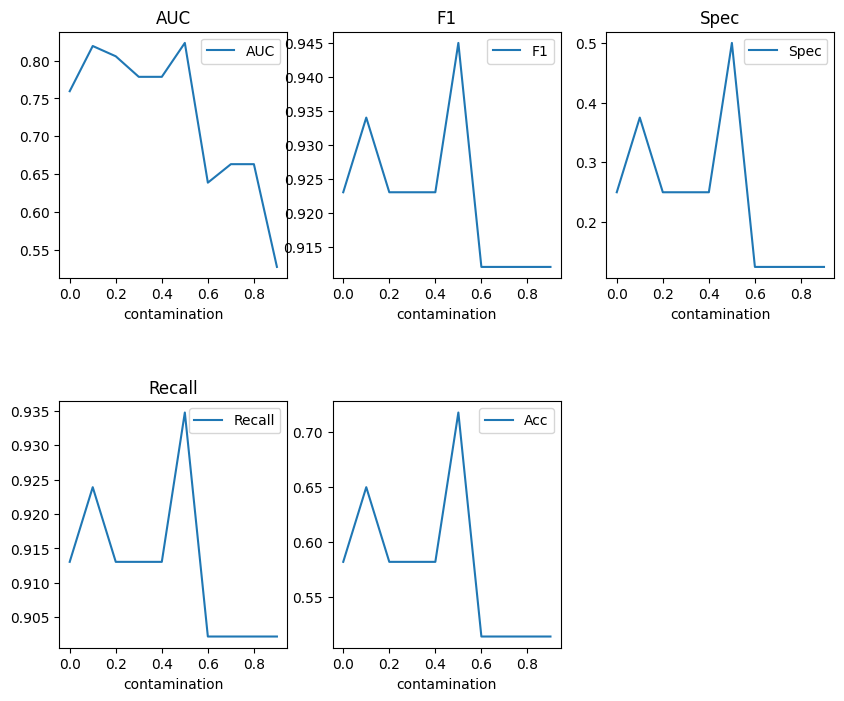

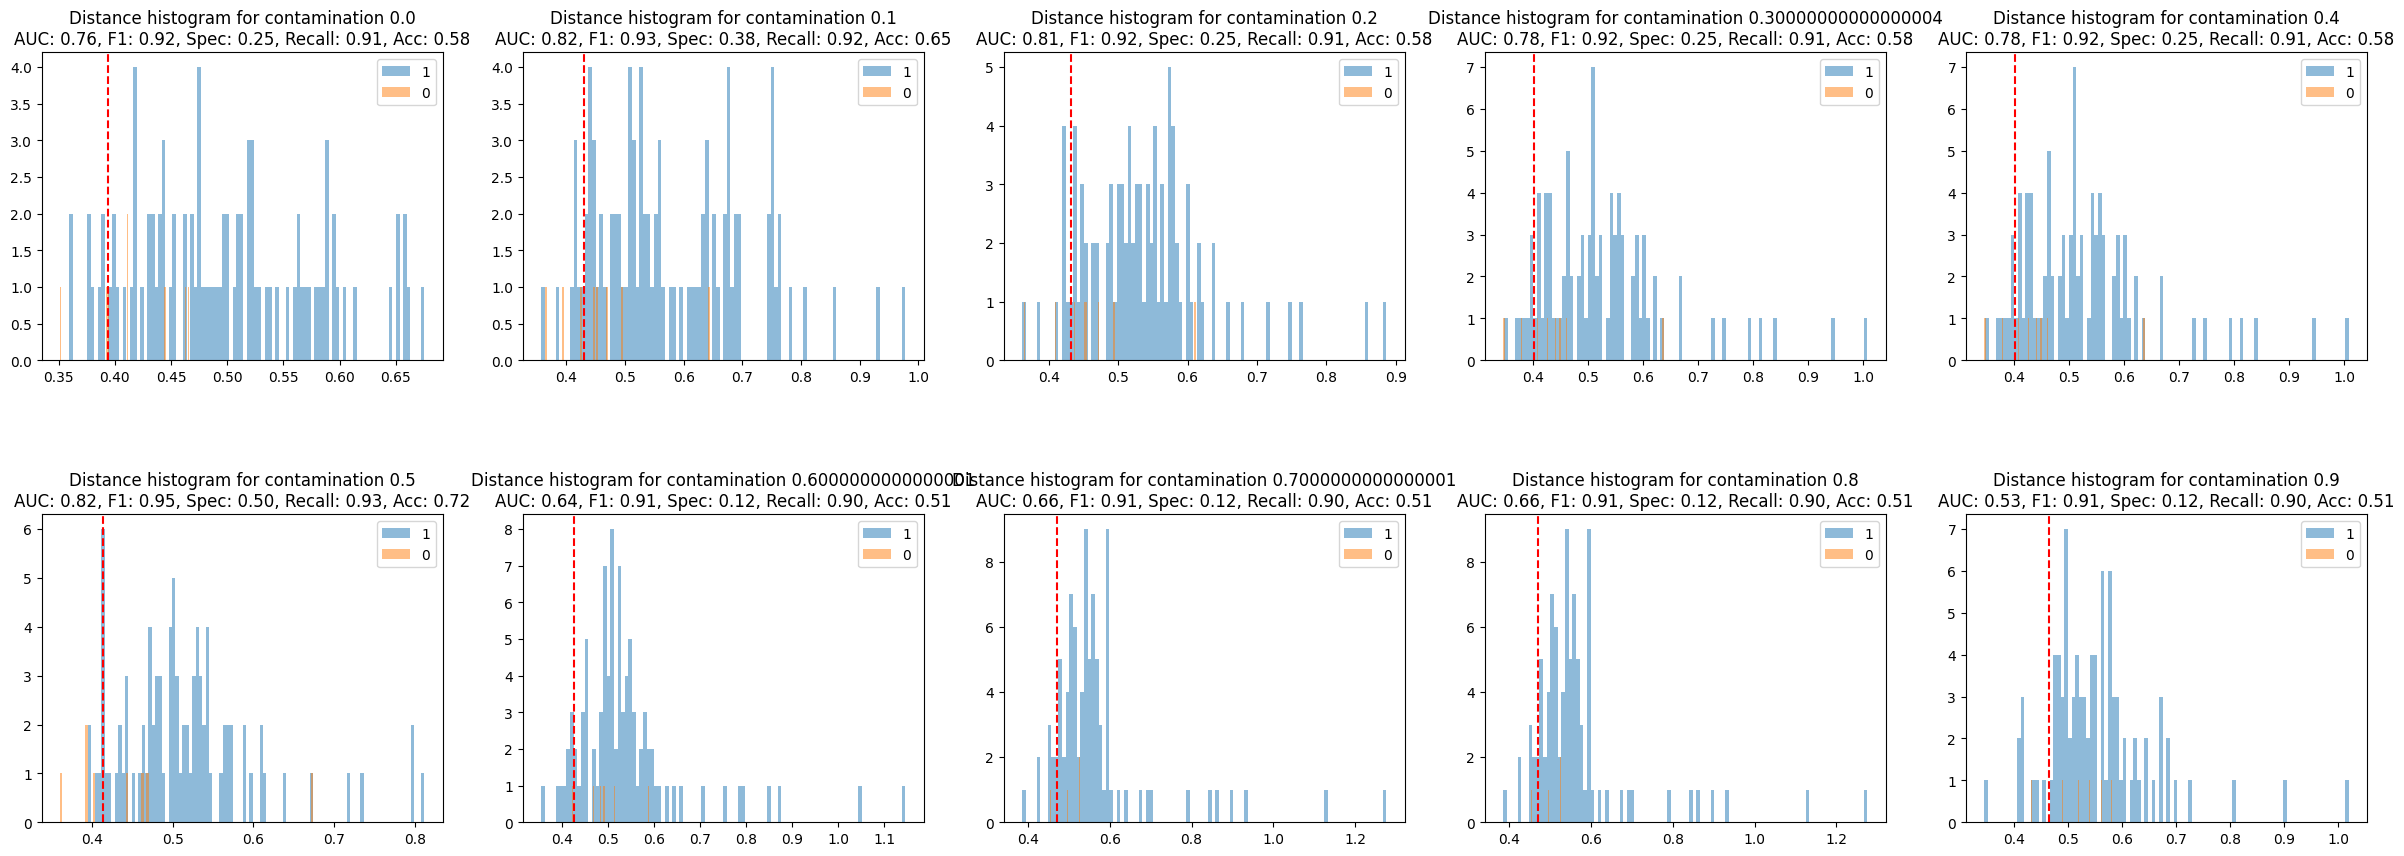

In [5]:
# Analyze result
# plot auc, f1, spec, recall, acc along contamination
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 3, 1)
plt.plot(contamination_range, results_contamination['auc'], label="AUC")
plt.xlabel('contamination')
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
plt.plot(contamination_range, results_contamination['f1'], label="F1")
plt.xlabel('contamination')
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
plt.plot(contamination_range, results_contamination['spec'], label="Spec")
plt.xlabel('contamination')
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
plt.plot(contamination_range, results_contamination['recall'], label="Recall")
plt.xlabel('contamination')
plt.legend()
plt.title("Recall")
plt.subplot(2, 3, 5)
plt.plot(contamination_range, results_contamination['acc'], label="Acc")
plt.xlabel('contamination')
plt.legend()

# plot the histogram for each contamination
plt.figure(figsize=(30, 10))
for i, contamination in enumerate(contamination_range):
    plt.subplot(2, int(np.ceil(len(contamination_range)/2)), i+1)
    plt.subplots_adjust(hspace=0.5)
    thres = np.percentile(results_contamination['df'][i]["minimum_dists"], 10)
    for label in results_contamination['df'][i]["label"].unique():
        plt.hist(results_contamination['df'][i][results_contamination['df'][i]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.legend()
    plt.title(f"Distance histogram for contamination {contamination}\nAUC: {results_contamination['auc'][i]:.2f}, F1: {results_contamination['f1'][i]:.2f}, Spec: {results_contamination['spec'][i]:.2f}, Recall: {results_contamination['recall'][i]:.2f}, Acc: {results_contamination['acc'][i]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")

Do experiment along train dataset size

In [11]:
args = init_args()
result_N = {}
result_N['df'], result_N['auc'], result_N['f1'], result_N['spec'], result_N['recall'], result_N['acc'] = [], [], [], [], [], []
N_range = np.arange(10, 110, 10)
for N in N_range:
    args.num_ref = N
    df, auc, f1, spec, recall, acc = train(args)
    result_N['df'].append(df)
    result_N['auc'].append(auc)
    result_N['f1'].append(f1)
    result_N['spec'].append(spec)
    result_N['recall'].append(recall)
    result_N['acc'].append(acc)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 38.096331395208836
Starting epoch 2
Epoch: 2, Train loss: 1.3165549524128437
Starting epoch 3
Epoch: 3, Train loss: 1.1121575826313346
Starting epoch 4
Epoch: 4, Train loss: 0.7561174453236162
Starting epoch 5
Epoch: 5, Train loss: 1.2201661529950798
Starting epoch 6
Epoch: 6, Train loss: 0.8428519236855209
Starting epoch 7
Epoch: 7, Train loss: 0.7608464163728058
Starting epoch 8
Epoch: 8, Train loss: 0.8405998267699033
Starting epoch 9
Epoch: 9, Train loss: 0.3574647625442594
Starting epoch 10
Epoch: 10, Train loss: 0.7218562387861311
--- 4.573978900909424 seconds ---
Normal class: 1
AUC: 0.9763407777777778
F1: 0.9753333333333334
Balanced accuracy: 0.8766666666666667
recall(the proportion of actual anomaly that are correctly identified): 0.9753333333333334
specificity(the proportion of actual normal that are correctly identified): 0.778
Average loss: 0.13589685895045353
auc: 0.95894, f1: 0.9753333333333334, spec: 0.778, recall: 0.975333333333333

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 21.18900381848216
Starting epoch 2
Epoch: 2, Train loss: 0.6251202836632729
Starting epoch 3
Epoch: 3, Train loss: 0.4799624147126451
Starting epoch 4
Epoch: 4, Train loss: 0.32803391152992845
Starting epoch 5
Epoch: 5, Train loss: 0.3793463698588312
Starting epoch 6
Epoch: 6, Train loss: 0.08289458001963794
Starting epoch 7
Epoch: 7, Train loss: 0.16858498970977961
Starting epoch 8
Epoch: 8, Train loss: 0.23358715837821364
Starting epoch 9
Epoch: 9, Train loss: 0.08301168899051845
Starting epoch 10
Epoch: 10, Train loss: 0.11542267017066479
--- 10.333197832107544 seconds ---
Normal class: 1
AUC: 0.9297128888888889
F1: 0.9696666666666667
Balanced accuracy: 0.8483333333333334
recall(the proportion of actual anomaly that are correctly identified): 0.9696666666666667
specificity(the proportion of actual normal that are correctly identified): 0.727
Average loss: 0.06931319940333476
auc: 0.744936111111111, f1: 0.9696666666666667, spec: 0.727, recall: 0

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 12.633852380576233
Starting epoch 2
Epoch: 2, Train loss: 0.3885317957106357
Starting epoch 3
Epoch: 3, Train loss: 0.6245185062444458
Starting epoch 4
Epoch: 4, Train loss: 0.38910235088163364
Starting epoch 5
Epoch: 5, Train loss: 0.7140784804243594
Starting epoch 6
Epoch: 6, Train loss: 0.17472514760835717
Starting epoch 7
Epoch: 7, Train loss: 0.6446214578890552
Starting epoch 8
Epoch: 8, Train loss: 0.3375381339962284
Starting epoch 9
Epoch: 9, Train loss: 0.11068889784316222
Starting epoch 10
Epoch: 10, Train loss: 0.1444626073197772
--- 14.251230478286743 seconds ---
Normal class: 1
AUC: 0.9130296666666667
F1: 0.9641111111111111
Balanced accuracy: 0.8205555555555556
recall(the proportion of actual anomaly that are correctly identified): 0.9641111111111111
specificity(the proportion of actual normal that are correctly identified): 0.677
Average loss: 0.08137228920153626
auc: 0.7153618888888889, f1: 0.9641111111111111, spec: 0.677, recall: 0.

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 7.0165266450028865
Starting epoch 2
Epoch: 2, Train loss: 0.13059961451217533
Starting epoch 3
Epoch: 3, Train loss: 0.12160036378772929
Starting epoch 4
Epoch: 4, Train loss: 0.07932942057959735
Starting epoch 5
Epoch: 5, Train loss: 0.14168419013731182
Starting epoch 6
Epoch: 6, Train loss: 0.03363483045250178
Starting epoch 7
Epoch: 7, Train loss: 0.11596661605872213
Starting epoch 8
Epoch: 8, Train loss: 0.030761462869122624
Starting epoch 9
Epoch: 9, Train loss: 0.030018509610090404
Starting epoch 10
Epoch: 10, Train loss: 0.024838947947137056
--- 19.27320885658264 seconds ---
Normal class: 1
AUC: 0.9249983333333333
F1: 0.9666666666666667
Balanced accuracy: 0.8333333333333333
recall(the proportion of actual anomaly that are correctly identified): 0.9666666666666667
specificity(the proportion of actual normal that are correctly identified): 0.7
Average loss: 0.07211948782603751
auc: 0.7275707777777777, f1: 0.9666666666666667, spec: 0.7, recall

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 5.525739245358855
Starting epoch 2
Epoch: 2, Train loss: 0.14294842859730125
Starting epoch 3
Epoch: 3, Train loss: 0.11768285224214196
Starting epoch 4
Epoch: 4, Train loss: 0.09823370875790716
Starting epoch 5
Epoch: 5, Train loss: 0.13355413229204716
Starting epoch 6
Epoch: 6, Train loss: 0.03205636207014322
Starting epoch 7
Epoch: 7, Train loss: 0.06183856861665845
Starting epoch 8
Epoch: 8, Train loss: 0.020386620284989478
Starting epoch 9
Epoch: 9, Train loss: 0.01936853160150349
Starting epoch 10
Epoch: 10, Train loss: 0.024830087954178452
--- 23.619781017303467 seconds ---
Normal class: 1
AUC: 0.9292287777777777
F1: 0.9674444444444444
Balanced accuracy: 0.8372222222222222
recall(the proportion of actual anomaly that are correctly identified): 0.9674444444444444
specificity(the proportion of actual normal that are correctly identified): 0.707
Average loss: 0.07153057820567968
auc: 0.7361387777777777, f1: 0.9674444444444444, spec: 0.707, rec

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 5.016771675234971
Starting epoch 2
Epoch: 2, Train loss: 0.09475890888522069
Starting epoch 3
Epoch: 3, Train loss: 0.12160644573159515
Starting epoch 4
Epoch: 4, Train loss: 0.06648816183054199
Starting epoch 5
Epoch: 5, Train loss: 0.09940600039747854
Starting epoch 6
Epoch: 6, Train loss: 0.04972898859220246
Starting epoch 7
Epoch: 7, Train loss: 0.10184016227722167
Starting epoch 8
Epoch: 8, Train loss: 0.02590473568998277
Starting epoch 9
Epoch: 9, Train loss: 0.021972392864214877
Starting epoch 10
Epoch: 10, Train loss: 0.025182657735422255
--- 28.863452434539795 seconds ---
Normal class: 1
AUC: 0.9260219999999999
F1: 0.9673333333333334
Balanced accuracy: 0.8366666666666667
recall(the proportion of actual anomaly that are correctly identified): 0.9673333333333334
specificity(the proportion of actual normal that are correctly identified): 0.706
Average loss: 0.07426891533288586
auc: 0.7199353333333333, f1: 0.9673333333333334, spec: 0.706, rec

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 3.7174468808607863
Starting epoch 2
Epoch: 2, Train loss: 0.11117648393847049
Starting epoch 3
Epoch: 3, Train loss: 0.15340584851801395
Starting epoch 4
Epoch: 4, Train loss: 0.07712916760439319
Starting epoch 5
Epoch: 5, Train loss: 0.13667821387893386
Starting epoch 6
Epoch: 6, Train loss: 0.036431539923484836
Starting epoch 7
Epoch: 7, Train loss: 0.06671433709561825
Starting epoch 8
Epoch: 8, Train loss: 0.06633214379793831
Starting epoch 9
Epoch: 9, Train loss: 0.03896923109755984
Starting epoch 10
Epoch: 10, Train loss: 0.020481598563492298
--- 33.26732039451599 seconds ---
Normal class: 1
AUC: 0.9024563333333333
F1: 0.9606666666666667
Balanced accuracy: 0.8033333333333333
recall(the proportion of actual anomaly that are correctly identified): 0.9606666666666667
specificity(the proportion of actual normal that are correctly identified): 0.646
Average loss: 0.08091262696677975
auc: 0.6791324444444444, f1: 0.9606666666666667, spec: 0.646, rec

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 2.868976002454292
Starting epoch 2
Epoch: 2, Train loss: 0.11007608415675349
Starting epoch 3
Epoch: 3, Train loss: 0.11880227499641478
Starting epoch 4
Epoch: 4, Train loss: 0.06407305155880749
Starting epoch 5
Epoch: 5, Train loss: 0.10598237701924518
Starting epoch 6
Epoch: 6, Train loss: 0.0658150339848362
Starting epoch 7
Epoch: 7, Train loss: 0.11541259856894612
Starting epoch 8
Epoch: 8, Train loss: 0.05729025495238602
Starting epoch 9
Epoch: 9, Train loss: 0.04538105253013782
Starting epoch 10
Epoch: 10, Train loss: 0.03359058946371078
--- 39.09496712684631 seconds ---
Normal class: 1
AUC: 0.914336
F1: 0.9628888888888889
Balanced accuracy: 0.8144444444444445
recall(the proportion of actual anomaly that are correctly identified): 0.9628888888888889
specificity(the proportion of actual normal that are correctly identified): 0.666
Average loss: 0.09420828522582694
auc: 0.6524083333333333, f1: 0.9628888888888889, spec: 0.666, recall: 0.9628888

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 2.55999956408826
Starting epoch 2
Epoch: 2, Train loss: 0.11520264182084551
Starting epoch 3
Epoch: 3, Train loss: 0.10692993709817529
Starting epoch 4
Epoch: 4, Train loss: 0.04833333508577198
Starting epoch 5
Epoch: 5, Train loss: 0.1136714556461407
Starting epoch 6
Epoch: 6, Train loss: 0.06027566732373089
Starting epoch 7
Epoch: 7, Train loss: 0.11834107807371766
Starting epoch 8
Epoch: 8, Train loss: 0.05692823796740009
Starting epoch 9
Epoch: 9, Train loss: 0.047363108880300486
Starting epoch 10
Epoch: 10, Train loss: 0.025471315194024808
--- 43.72836136817932 seconds ---
Normal class: 1
AUC: 0.9177469444444445
F1: 0.9577777777777777
Balanced accuracy: 0.7888888888888889
recall(the proportion of actual anomaly that are correctly identified): 0.9577777777777777
specificity(the proportion of actual normal that are correctly identified): 0.62
Average loss: 0.10818058520320689
auc: 0.6453070000000001, f1: 0.9577777777777777, spec: 0.62, recall: 

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 2.6945483291591517
Starting epoch 2
Epoch: 2, Train loss: 0.09478788315318525
Starting epoch 3
Epoch: 3, Train loss: 0.1011797946644947
Starting epoch 4
Epoch: 4, Train loss: 0.09424393048277124
Starting epoch 5
Epoch: 5, Train loss: 0.06255778037011624
Starting epoch 6
Epoch: 6, Train loss: 0.032410745427478106
Starting epoch 7
Epoch: 7, Train loss: 0.044197865016758445
Starting epoch 8
Epoch: 8, Train loss: 0.028959316059481353
Starting epoch 9
Epoch: 9, Train loss: 0.022176113517489285
Starting epoch 10
Epoch: 10, Train loss: 0.018700748500414192
--- 48.777361154556274 seconds ---
Normal class: 1
AUC: 0.9025307777777777
F1: 0.9624444444444444
Balanced accuracy: 0.8122222222222222
recall(the proportion of actual anomaly that are correctly identified): 0.9624444444444444
specificity(the proportion of actual normal that are correctly identified): 0.662
Average loss: 0.08883890615773864
auc: 0.6884651111111111, f1: 0.9624444444444444, spec: 0.662, 

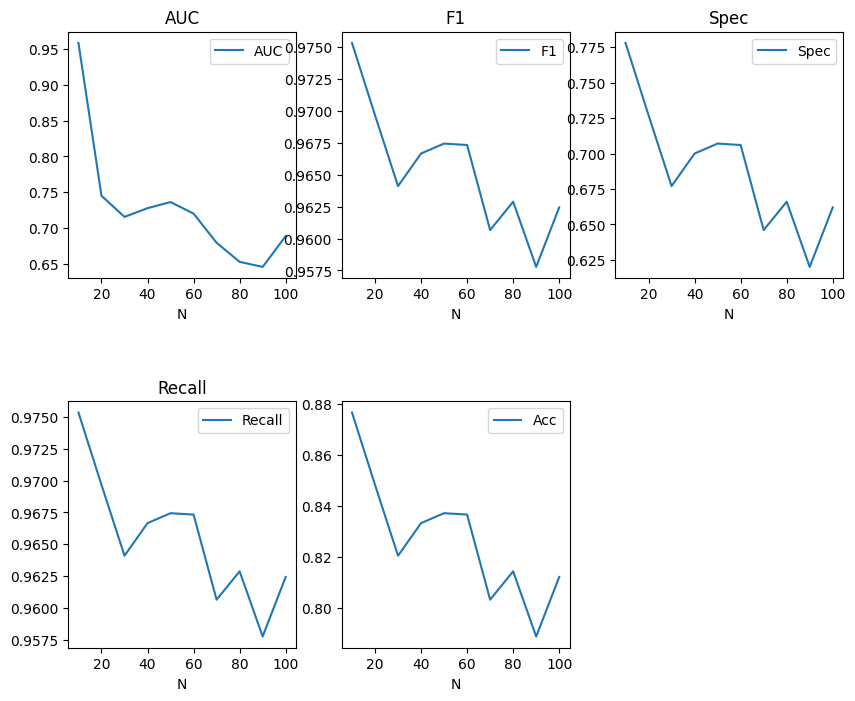

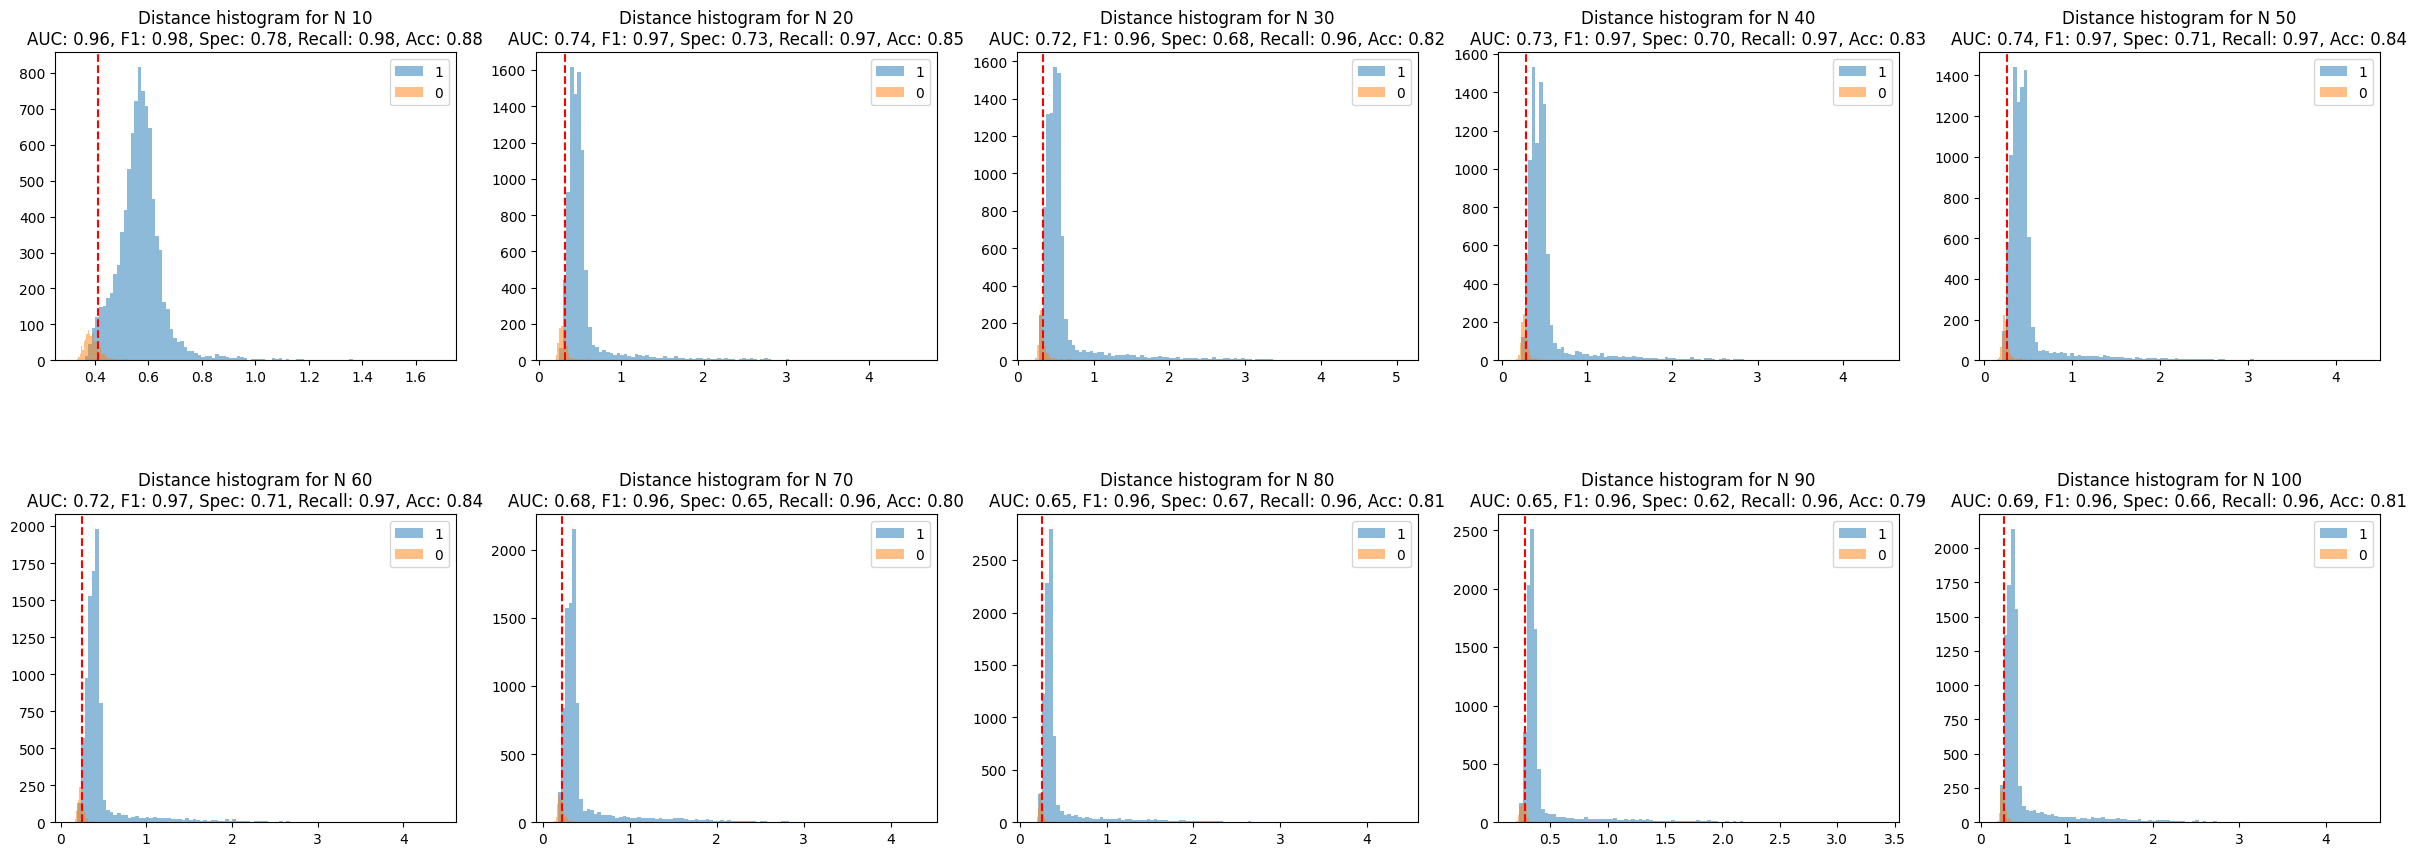

In [12]:
# Analyze result
# plot auc, f1, spec, recall, acc along N
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 3, 1)
plt.plot(N_range, result_N['auc'], label="AUC")
plt.xlabel('N')
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
plt.plot(N_range, result_N['f1'], label="F1")
plt.xlabel('N')
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
plt.plot(N_range, result_N['spec'], label="Spec")
plt.xlabel('N')
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
plt.plot(N_range, result_N['recall'], label="Recall")
plt.xlabel('N')
plt.legend()
plt.title("Recall")
plt.subplot(2, 3, 5)
plt.plot(N_range, result_N['acc'], label="Acc")
plt.xlabel('N')
plt.legend()

# plot the histogram for each N
plt.figure(figsize=(30, 10))
for i, N in enumerate(N_range):
    plt.subplot(2, int(np.ceil(len(N_range)/2)), i+1)
    plt.subplots_adjust(hspace=0.5)
    thres = np.percentile(result_N['df'][i]["minimum_dists"], 10)
    for label in result_N['df'][i]["label"].unique():
        plt.hist(result_N['df'][i][result_N['df'][i]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.legend()
    plt.title(f"Distance histogram for N {N}\nAUC: {result_N['auc'][i]:.2f}, F1: {result_N['f1'][i]:.2f}, Spec: {result_N['spec'][i]:.2f}, Recall: {result_N['recall'][i]:.2f}, Acc: {result_N['acc'][i]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")

Do experiment along weight decay

In [13]:
args = init_args()
args.normal_class = 4
result_weight_decay = {}
result_weight_decay['df'], result_weight_decay['auc'], result_weight_decay['f1'], result_weight_decay['spec'], result_weight_decay['recall'], result_weight_decay['acc'] = [], [], [], [], [], []
weight_decay_range = np.arange(0, 0.1, 0.01)
for weight_decay in weight_decay_range:
    args.weight_decay = weight_decay
    df, auc, f1, spec, recall, acc = train(args)
    result_weight_decay['df'].append(df)
    result_weight_decay['auc'].append(auc)
    result_weight_decay['f1'].append(f1)
    result_weight_decay['spec'].append(spec)
    result_weight_decay['recall'].append(recall)
    result_weight_decay['acc'].append(acc)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70335369110107
Starting epoch 2
Epoch: 2, Train loss: 8.477771258354187
Starting epoch 3
Epoch: 3, Train loss: 5.135680389404297
Starting epoch 4
Epoch: 4, Train loss: 3.272572362422943
Starting epoch 5
Epoch: 5, Train loss: 3.015154904127121
Starting epoch 6
Epoch: 6, Train loss: 2.2040507376194
Starting epoch 7
Epoch: 7, Train loss: 1.759934949874878
Starting epoch 8
Epoch: 8, Train loss: 1.4601951658725738
Starting epoch 9
Epoch: 9, Train loss: 0.9639248281717301
Starting epoch 10
Epoch: 10, Train loss: 1.0818049967288972
--- 4.4791412353515625 seconds ---
Normal class: 4
AUC: 0.9219373333333333
F1: 0.9508888888888889
Balanced accuracy: 0.7544444444444445
recall(the proportion of actual anomaly that are correctly identified): 0.9508888888888889
specificity(the proportion of actual normal that are correctly identified): 0.558
Average loss: 0.2129736286073923
auc: 0.9173268888888888, f1: 0.9508888888888889, spec: 0.558, recall: 0.9508888888888

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.702887010574344
Starting epoch 2
Epoch: 2, Train loss: 8.478896379470825
Starting epoch 3
Epoch: 3, Train loss: 5.1346936345100405
Starting epoch 4
Epoch: 4, Train loss: 3.2732054114341738
Starting epoch 5
Epoch: 5, Train loss: 3.018530970811844
Starting epoch 6
Epoch: 6, Train loss: 2.1977142572402952
Starting epoch 7
Epoch: 7, Train loss: 1.7618624091148376
Starting epoch 8
Epoch: 8, Train loss: 1.4596148073673247
Starting epoch 9
Epoch: 9, Train loss: 0.9620444118976593
Starting epoch 10
Epoch: 10, Train loss: 1.0868270754814149
--- 4.360396146774292 seconds ---
Normal class: 4
AUC: 0.9217928888888889
F1: 0.951
Balanced accuracy: 0.755
recall(the proportion of actual anomaly that are correctly identified): 0.951
specificity(the proportion of actual normal that are correctly identified): 0.559
Average loss: 0.21328809550881386
auc: 0.9170553333333334, f1: 0.951, spec: 0.559, recall: 0.951, acc: 0.755


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70242137908936
Starting epoch 2
Epoch: 2, Train loss: 8.478268003463745
Starting epoch 3
Epoch: 3, Train loss: 5.132928526401519
Starting epoch 4
Epoch: 4, Train loss: 3.2723461389541626
Starting epoch 5
Epoch: 5, Train loss: 3.018062615394592
Starting epoch 6
Epoch: 6, Train loss: 2.199885392189026
Starting epoch 7
Epoch: 7, Train loss: 1.7590653061866761
Starting epoch 8
Epoch: 8, Train loss: 1.4574560165405273
Starting epoch 9
Epoch: 9, Train loss: 0.9624554872512817
Starting epoch 10
Epoch: 10, Train loss: 1.0836160719394683
--- 4.3754918575286865 seconds ---
Normal class: 4
AUC: 0.9219838888888888
F1: 0.9511111111111111
Balanced accuracy: 0.7555555555555555
recall(the proportion of actual anomaly that are correctly identified): 0.9511111111111111
specificity(the proportion of actual normal that are correctly identified): 0.56
Average loss: 0.21290748145520688
auc: 0.9172258888888889, f1: 0.9511111111111111, spec: 0.56, recall: 0.9511111111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.7019862651825
Starting epoch 2
Epoch: 2, Train loss: 8.477759146690369
Starting epoch 3
Epoch: 3, Train loss: 5.132160866260529
Starting epoch 4
Epoch: 4, Train loss: 3.272717821598053
Starting epoch 5
Epoch: 5, Train loss: 3.013942527770996
Starting epoch 6
Epoch: 6, Train loss: 2.1980586409568788
Starting epoch 7
Epoch: 7, Train loss: 1.7574646770954132
Starting epoch 8
Epoch: 8, Train loss: 1.4569200932979585
Starting epoch 9
Epoch: 9, Train loss: 0.9635495722293854
Starting epoch 10
Epoch: 10, Train loss: 1.084756225347519
--- 4.3872902393341064 seconds ---
Normal class: 4
AUC: 0.9217606666666667
F1: 0.9508888888888889
Balanced accuracy: 0.7544444444444445
recall(the proportion of actual anomaly that are correctly identified): 0.9508888888888889
specificity(the proportion of actual normal that are correctly identified): 0.558
Average loss: 0.2127660320237279
auc: 0.9170796666666667, f1: 0.9508888888888889, spec: 0.558, recall: 0.95088888888

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70152053833008
Starting epoch 2
Epoch: 2, Train loss: 8.47712962627411
Starting epoch 3
Epoch: 3, Train loss: 5.131513166427612
Starting epoch 4
Epoch: 4, Train loss: 3.27251683473587
Starting epoch 5
Epoch: 5, Train loss: 3.0121383905410766
Starting epoch 6
Epoch: 6, Train loss: 2.195216292142868
Starting epoch 7
Epoch: 7, Train loss: 1.7567944765090941
Starting epoch 8
Epoch: 8, Train loss: 1.455530822277069
Starting epoch 9
Epoch: 9, Train loss: 0.9617540925741196
Starting epoch 10
Epoch: 10, Train loss: 1.0854463219642638
--- 4.4385857582092285 seconds ---
Normal class: 4
AUC: 0.9217816666666667
F1: 0.9507777777777778
Balanced accuracy: 0.7538888888888889
recall(the proportion of actual anomaly that are correctly identified): 0.9507777777777778
specificity(the proportion of actual normal that are correctly identified): 0.557
Average loss: 0.21262708149760962
auc: 0.9171, f1: 0.9507777777777778, spec: 0.557, recall: 0.9507777777777778, acc: 

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70268597602844
Starting epoch 2
Epoch: 2, Train loss: 8.480275106430053
Starting epoch 3
Epoch: 3, Train loss: 5.132882344722748
Starting epoch 4
Epoch: 4, Train loss: 3.2683059215545653
Starting epoch 5
Epoch: 5, Train loss: 3.00492884516716
Starting epoch 6
Epoch: 6, Train loss: 2.199838864803314
Starting epoch 7
Epoch: 7, Train loss: 1.7498291194438935
Starting epoch 8
Epoch: 8, Train loss: 1.4525889813899995
Starting epoch 9
Epoch: 9, Train loss: 0.9583053946495056
Starting epoch 10
Epoch: 10, Train loss: 1.087459644675255
--- 4.302938461303711 seconds ---
Normal class: 4
AUC: 0.9220246111111111
F1: 0.9512222222222222
Balanced accuracy: 0.7561111111111112
recall(the proportion of actual anomaly that are correctly identified): 0.9512222222222222
specificity(the proportion of actual normal that are correctly identified): 0.561
Average loss: 0.21249942053854465
auc: 0.9173256666666667, f1: 0.9512222222222222, spec: 0.561, recall: 0.95122222222

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70221843719482
Starting epoch 2
Epoch: 2, Train loss: 8.479644584655762
Starting epoch 3
Epoch: 3, Train loss: 5.132222986221313
Starting epoch 4
Epoch: 4, Train loss: 3.267958331108093
Starting epoch 5
Epoch: 5, Train loss: 3.0036468684673308
Starting epoch 6
Epoch: 6, Train loss: 2.1990774273872375
Starting epoch 7
Epoch: 7, Train loss: 1.748768585920334
Starting epoch 8
Epoch: 8, Train loss: 1.4518933176994324
Starting epoch 9
Epoch: 9, Train loss: 0.9574576139450073
Starting epoch 10
Epoch: 10, Train loss: 1.087309977412224
--- 3.730624198913574 seconds ---
Normal class: 4
AUC: 0.9220385555555556
F1: 0.9513333333333334
Balanced accuracy: 0.7566666666666667
recall(the proportion of actual anomaly that are correctly identified): 0.9513333333333334
specificity(the proportion of actual normal that are correctly identified): 0.562
Average loss: 0.2125611797809601
auc: 0.9172882222222223, f1: 0.9513333333333334, spec: 0.562, recall: 0.95133333333

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70178718566895
Starting epoch 2
Epoch: 2, Train loss: 8.479113626480103
Starting epoch 3
Epoch: 3, Train loss: 5.131661462783813
Starting epoch 4
Epoch: 4, Train loss: 3.2676895022392274
Starting epoch 5
Epoch: 5, Train loss: 3.0027094423770904
Starting epoch 6
Epoch: 6, Train loss: 2.196894121170044
Starting epoch 7
Epoch: 7, Train loss: 1.7464258313179015
Starting epoch 8
Epoch: 8, Train loss: 1.4510162234306336
Starting epoch 9
Epoch: 9, Train loss: 0.9580980837345123
Starting epoch 10
Epoch: 10, Train loss: 1.0835662841796876
--- 3.79618239402771 seconds ---
Normal class: 4
AUC: 0.9219991111111112
F1: 0.9511111111111111
Balanced accuracy: 0.7555555555555555
recall(the proportion of actual anomaly that are correctly identified): 0.9511111111111111
specificity(the proportion of actual normal that are correctly identified): 0.56
Average loss: 0.21244877695411443
auc: 0.9171575555555556, f1: 0.9511111111111111, spec: 0.56, recall: 0.95111111111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.70131931304932
Starting epoch 2
Epoch: 2, Train loss: 8.478442215919495
Starting epoch 3
Epoch: 3, Train loss: 5.131011319160462
Starting epoch 4
Epoch: 4, Train loss: 3.2674875140190123
Starting epoch 5
Epoch: 5, Train loss: 3.0000075578689573
Starting epoch 6
Epoch: 6, Train loss: 2.195249152183533
Starting epoch 7
Epoch: 7, Train loss: 1.7453759074211121
Starting epoch 8
Epoch: 8, Train loss: 1.4465372264385223
Starting epoch 9
Epoch: 9, Train loss: 0.9548396378755569
Starting epoch 10
Epoch: 10, Train loss: 1.0828021198511124
--- 3.861931324005127 seconds ---
Normal class: 4
AUC: 0.9219561666666667
F1: 0.9512222222222222
Balanced accuracy: 0.7561111111111112
recall(the proportion of actual anomaly that are correctly identified): 0.9512222222222222
specificity(the proportion of actual normal that are correctly identified): 0.561
Average loss: 0.21225771318942308
auc: 0.9172121111111111, f1: 0.9512222222222222, spec: 0.561, recall: 0.95122222

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 37.700851392745975
Starting epoch 2
Epoch: 2, Train loss: 8.477810025215149
Starting epoch 3
Epoch: 3, Train loss: 5.130331194400787
Starting epoch 4
Epoch: 4, Train loss: 3.2666945815086366
Starting epoch 5
Epoch: 5, Train loss: 2.9994793593883515
Starting epoch 6
Epoch: 6, Train loss: 2.194952058792114
Starting epoch 7
Epoch: 7, Train loss: 1.746597558259964
Starting epoch 8
Epoch: 8, Train loss: 1.445531463623047
Starting epoch 9
Epoch: 9, Train loss: 0.9541117399930954
Starting epoch 10
Epoch: 10, Train loss: 1.082631379365921
--- 3.8712384700775146 seconds ---
Normal class: 4
AUC: 0.9219947777777778
F1: 0.9511111111111111
Balanced accuracy: 0.7555555555555555
recall(the proportion of actual anomaly that are correctly identified): 0.9511111111111111
specificity(the proportion of actual normal that are correctly identified): 0.56
Average loss: 0.21219588914126156
auc: 0.9171741111111111, f1: 0.9511111111111111, spec: 0.56, recall: 0.95111111111

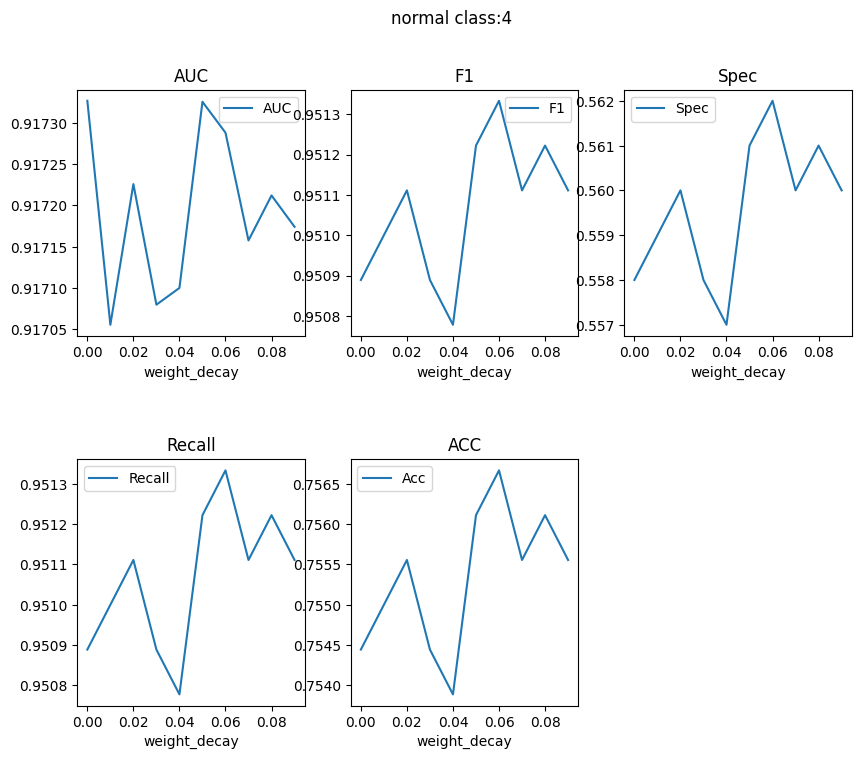

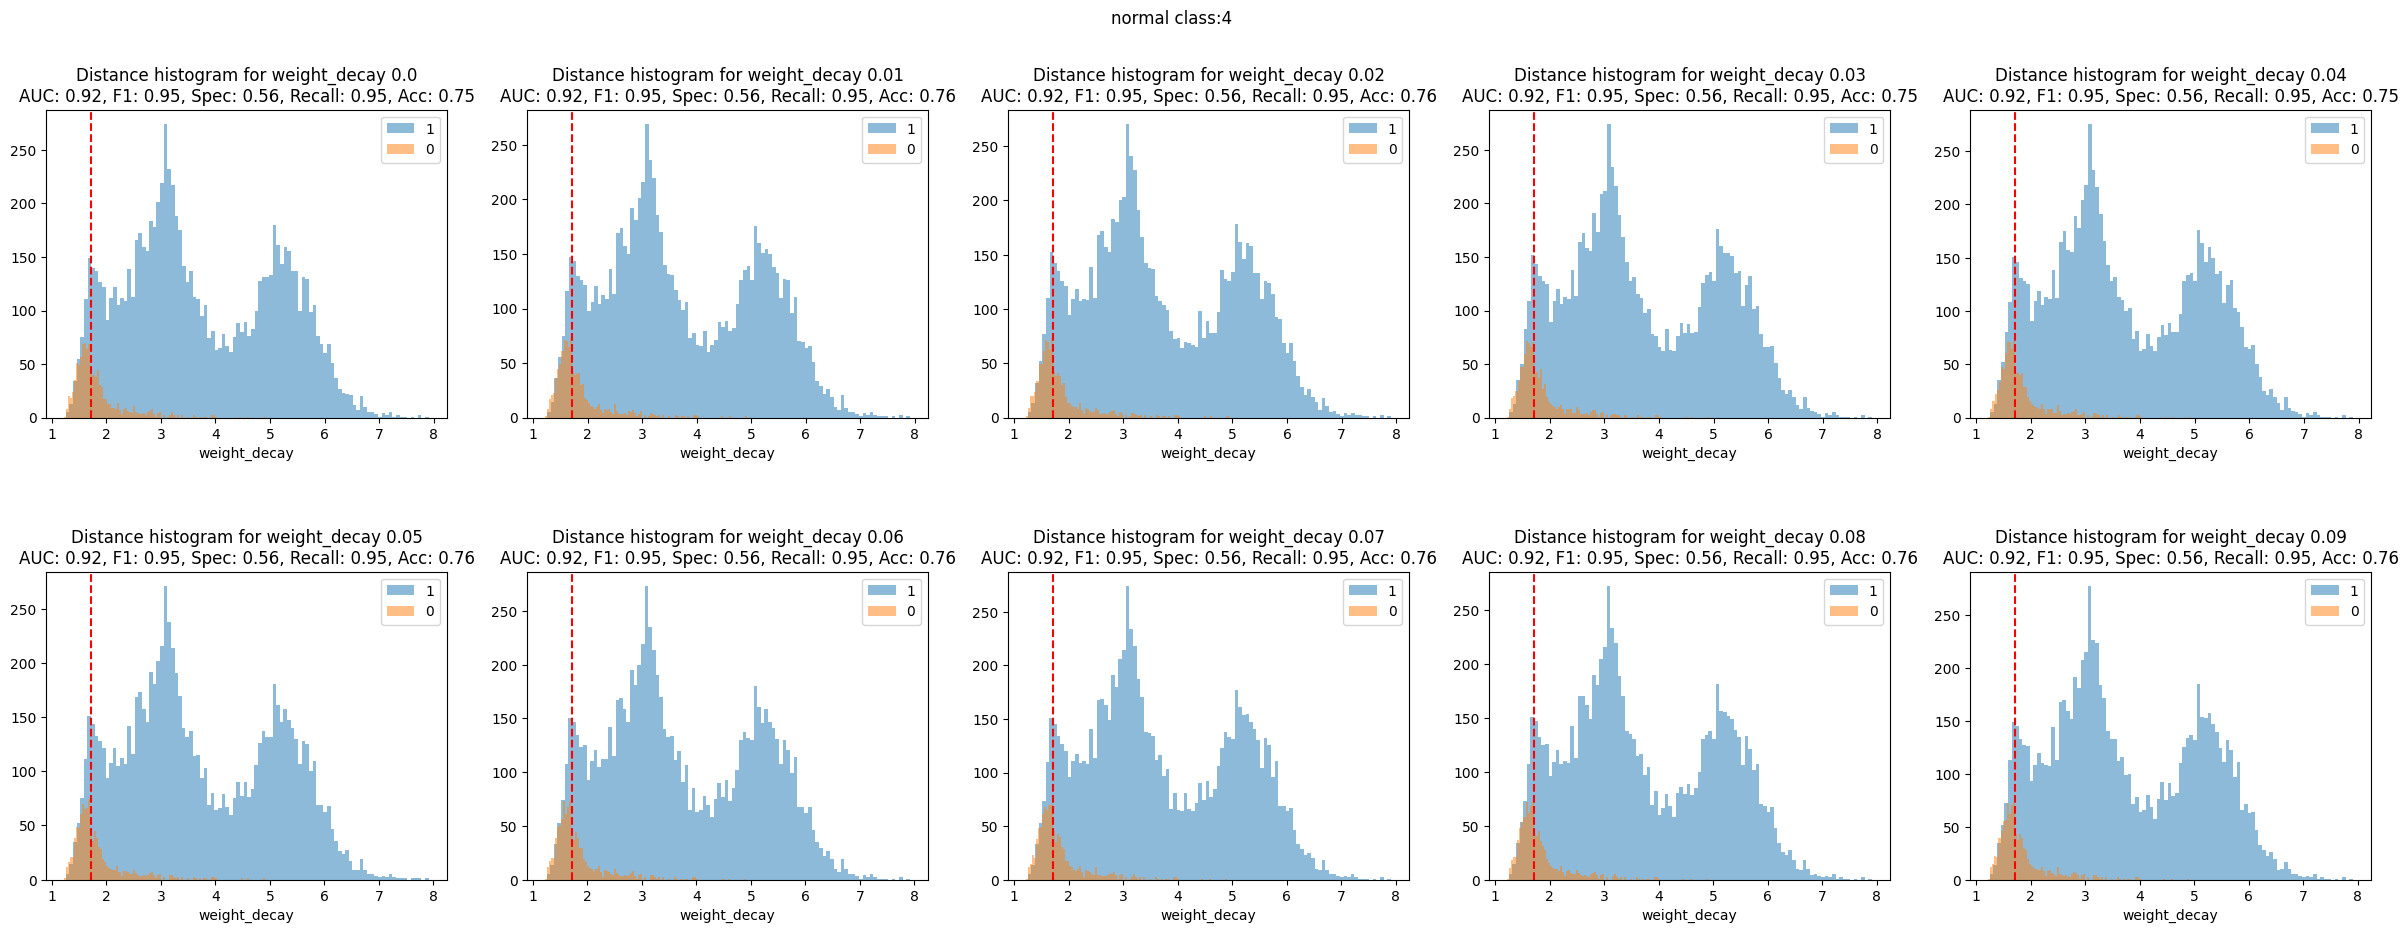

In [14]:
# Analyze result
# plot auc, f1, spec, recall, acc along weight_decay
plt.figure(figsize=(10, 8))
plt.suptitle(f'normal class:{args.normal_class}')
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 3, 1)
plt.xlabel('weight_decay')
plt.plot(weight_decay_range, result_weight_decay['auc'], label="AUC")
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
plt.xlabel('weight_decay')
plt.plot(weight_decay_range, result_weight_decay['f1'], label="F1")
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
plt.xlabel('weight_decay')
plt.plot(weight_decay_range, result_weight_decay['spec'], label="Spec")
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
plt.xlabel('weight_decay')
plt.plot(weight_decay_range, result_weight_decay['recall'], label="Recall")
plt.legend()
plt.title("Recall")
plt.subplot(2, 3, 5)
plt.xlabel('weight_decay')
plt.plot(weight_decay_range, result_weight_decay['acc'], label="Acc")
plt.legend()
plt.title('ACC')

# plot the histogram for each weight_decay
plt.figure(figsize=(30, 10))
plt.suptitle(f'normal class:{args.normal_class}')
for i, weight_decay in enumerate(weight_decay_range):
    plt.subplot(2, int(np.ceil(len(weight_decay_range)/2)), i+1)
    plt.subplots_adjust(hspace=0.5)
    thres = np.percentile(result_weight_decay['df'][i]["minimum_dists"], 10)
    for label in result_weight_decay['df'][i]["label"].unique():
        plt.hist(result_weight_decay['df'][i][result_weight_decay['df'][i]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.legend()
    plt.title(f"Distance histogram for weight_decay {weight_decay}\nAUC: {result_weight_decay['auc'][i]:.2f}, F1: {result_weight_decay['f1'][i]:.2f}, Spec: {result_weight_decay['spec'][i]:.2f}, Recall: {result_weight_decay['recall'][i]:.2f}, Acc: {result_weight_decay['acc'][i]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")
    plt.xlabel('weight_decay')

Do experiment along learning rate

In [20]:
args = init_args()
args.normal_class = 4
result_learning_rate = {}
result_learning_rate['df'], result_learning_rate['auc'], result_learning_rate['f1'], result_learning_rate['spec'], result_learning_rate['recall'], result_learning_rate['acc'] = [], [], [], [], [], []
learning_rate_range = np.arange(1e-5, 1e-4, 1e-5)
for lr in learning_rate_range:
    args.lr = lr
    df, auc, f1, spec, recall, acc = train(args)
    result_learning_rate['df'].append(df)
    result_learning_rate['auc'].append(auc)
    result_learning_rate['f1'].append(f1)
    result_learning_rate['spec'].append(spec)
    result_learning_rate['recall'].append(recall)
    result_learning_rate['acc'].append(acc)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 67.80193214416504
Starting epoch 2
Epoch: 2, Train loss: 42.968774223327635
Starting epoch 3
Epoch: 3, Train loss: 32.86880760192871
Starting epoch 4
Epoch: 4, Train loss: 27.092476654052735
Starting epoch 5
Epoch: 5, Train loss: 16.83440399169922
Starting epoch 6
Epoch: 6, Train loss: 14.757762479782105
Starting epoch 7
Epoch: 7, Train loss: 13.696891784667969
Starting epoch 8
Epoch: 8, Train loss: 11.534450435638428
Starting epoch 9
Epoch: 9, Train loss: 8.547567558288574
Starting epoch 10
Epoch: 10, Train loss: 8.701946830749511
--- 4.3183276653289795 seconds ---
Normal class: 4
AUC: 0.9334696666666668
F1: 0.9528888888888889
Balanced accuracy: 0.7644444444444445
recall(the proportion of actual anomaly that are correctly identified): 0.9528888888888889
specificity(the proportion of actual normal that are correctly identified): 0.576
Average loss: 1.1464950314116478
auc: 0.9311081111111111, f1: 0.9528888888888889, spec: 0.576, recall: 0.952888888

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 60.918173217773436
Starting epoch 2
Epoch: 2, Train loss: 28.17348709106445
Starting epoch 3
Epoch: 3, Train loss: 18.18504219055176
Starting epoch 4
Epoch: 4, Train loss: 12.92194652557373
Starting epoch 5
Epoch: 5, Train loss: 8.492871809005738
Starting epoch 6
Epoch: 6, Train loss: 6.97382242679596
Starting epoch 7
Epoch: 7, Train loss: 6.475032889842987
Starting epoch 8
Epoch: 8, Train loss: 5.463664400577545
Starting epoch 9
Epoch: 9, Train loss: 3.8256416440010073
Starting epoch 10
Epoch: 10, Train loss: 4.879349613189698
--- 4.289599895477295 seconds ---
Normal class: 4
AUC: 0.9321401111111111
F1: 0.953
Balanced accuracy: 0.7649999999999999
recall(the proportion of actual anomaly that are correctly identified): 0.953
specificity(the proportion of actual normal that are correctly identified): 0.577
Average loss: 0.6217300731700659
auc: 0.9307598888888888, f1: 0.953, spec: 0.577, recall: 0.953, acc: 0.7649999999999999


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 55.41515197753906
Starting epoch 2
Epoch: 2, Train loss: 20.22914628982544
Starting epoch 3
Epoch: 3, Train loss: 12.185276222229003
Starting epoch 4
Epoch: 4, Train loss: 8.087771320343018
Starting epoch 5
Epoch: 5, Train loss: 6.134980058670044
Starting epoch 6
Epoch: 6, Train loss: 4.939553618431091
Starting epoch 7
Epoch: 7, Train loss: 4.7004534840583805
Starting epoch 8
Epoch: 8, Train loss: 4.046615743637085
Starting epoch 9
Epoch: 9, Train loss: 2.8023828625679017
Starting epoch 10
Epoch: 10, Train loss: 3.804555594921112
--- 4.432392597198486 seconds ---
Normal class: 4
AUC: 0.9315370000000001
F1: 0.9532222222222222
Balanced accuracy: 0.7661111111111111
recall(the proportion of actual anomaly that are correctly identified): 0.9532222222222222
specificity(the proportion of actual normal that are correctly identified): 0.579
Average loss: 0.48838589463889603
auc: 0.9306957777777778, f1: 0.9532222222222222, spec: 0.579, recall: 0.95322222222

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 51.08554954528809
Starting epoch 2
Epoch: 2, Train loss: 15.831438112258912
Starting epoch 3
Epoch: 3, Train loss: 9.226077556610107
Starting epoch 4
Epoch: 4, Train loss: 6.071621894836426
Starting epoch 5
Epoch: 5, Train loss: 5.135281658172607
Starting epoch 6
Epoch: 6, Train loss: 4.142817783355713
Starting epoch 7
Epoch: 7, Train loss: 3.867309367656708
Starting epoch 8
Epoch: 8, Train loss: 3.369216775894165
Starting epoch 9
Epoch: 9, Train loss: 2.2978338301181793
Starting epoch 10
Epoch: 10, Train loss: 3.192602849006653
--- 4.400762319564819 seconds ---
Normal class: 4
AUC: 0.9315183333333334
F1: 0.9532222222222222
Balanced accuracy: 0.7661111111111111
recall(the proportion of actual anomaly that are correctly identified): 0.9532222222222222
specificity(the proportion of actual normal that are correctly identified): 0.579
Average loss: 0.42189395864486695
auc: 0.9310529999999999, f1: 0.9532222222222222, spec: 0.579, recall: 0.953222222222

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 47.63608283996582
Starting epoch 2
Epoch: 2, Train loss: 13.240142774581908
Starting epoch 3
Epoch: 3, Train loss: 7.6380703210830685
Starting epoch 4
Epoch: 4, Train loss: 4.953804302215576
Starting epoch 5
Epoch: 5, Train loss: 4.586761629581451
Starting epoch 6
Epoch: 6, Train loss: 3.6455925345420837
Starting epoch 7
Epoch: 7, Train loss: 3.38331161737442
Starting epoch 8
Epoch: 8, Train loss: 2.925983101129532
Starting epoch 9
Epoch: 9, Train loss: 1.9765130400657653
Starting epoch 10
Epoch: 10, Train loss: 2.695677840709686
--- 4.3133156299591064 seconds ---
Normal class: 4
AUC: 0.9307643333333333
F1: 0.9536666666666667
Balanced accuracy: 0.7683333333333333
recall(the proportion of actual anomaly that are correctly identified): 0.9536666666666667
specificity(the proportion of actual normal that are correctly identified): 0.583
Average loss: 0.37875256783246997
auc: 0.930385, f1: 0.9536666666666667, spec: 0.583, recall: 0.9536666666666667, ac

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 44.84446392059326
Starting epoch 2
Epoch: 2, Train loss: 11.56679048538208
Starting epoch 3
Epoch: 3, Train loss: 6.705945301055908
Starting epoch 4
Epoch: 4, Train loss: 4.37546489238739
Starting epoch 5
Epoch: 5, Train loss: 4.116055738925934
Starting epoch 6
Epoch: 6, Train loss: 3.2844241142272947
Starting epoch 7
Epoch: 7, Train loss: 2.941995370388031
Starting epoch 8
Epoch: 8, Train loss: 2.5368167757987976
Starting epoch 9
Epoch: 9, Train loss: 1.7097535848617553
Starting epoch 10
Epoch: 10, Train loss: 2.2458202302455903
--- 4.339787006378174 seconds ---
Normal class: 4
AUC: 0.9292324444444445
F1: 0.9526666666666667
Balanced accuracy: 0.7633333333333333
recall(the proportion of actual anomaly that are correctly identified): 0.9526666666666667
specificity(the proportion of actual normal that are correctly identified): 0.574
Average loss: 0.34091338508903984
auc: 0.9286911111111111, f1: 0.9526666666666667, spec: 0.574, recall: 0.95266666666

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 42.52611446380615
Starting epoch 2
Epoch: 2, Train loss: 10.418316912651061
Starting epoch 3
Epoch: 3, Train loss: 6.082265686988831
Starting epoch 4
Epoch: 4, Train loss: 3.936704730987549
Starting epoch 5
Epoch: 5, Train loss: 3.7765793561935426
Starting epoch 6
Epoch: 6, Train loss: 2.953162747621536
Starting epoch 7
Epoch: 7, Train loss: 2.6012027263641357
Starting epoch 8
Epoch: 8, Train loss: 2.2431608736515045
Starting epoch 9
Epoch: 9, Train loss: 1.4952394902706145
Starting epoch 10
Epoch: 10, Train loss: 1.898477667570114
--- 4.306484937667847 seconds ---
Normal class: 4
AUC: 0.9271764444444444
F1: 0.9514444444444444
Balanced accuracy: 0.7572222222222222
recall(the proportion of actual anomaly that are correctly identified): 0.9514444444444444
specificity(the proportion of actual normal that are correctly identified): 0.563
Average loss: 0.3013687741690874
auc: 0.9263155555555556, f1: 0.9514444444444444, spec: 0.563, recall: 0.9514444444

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 40.61045694351196
Starting epoch 2
Epoch: 2, Train loss: 9.548710107803345
Starting epoch 3
Epoch: 3, Train loss: 5.684310472011566
Starting epoch 4
Epoch: 4, Train loss: 3.669397497177124
Starting epoch 5
Epoch: 5, Train loss: 3.493602532148361
Starting epoch 6
Epoch: 6, Train loss: 2.6879065155982973
Starting epoch 7
Epoch: 7, Train loss: 2.2700491845607758
Starting epoch 8
Epoch: 8, Train loss: 1.9458917677402496
Starting epoch 9
Epoch: 9, Train loss: 1.2806351065635682
Starting epoch 10
Epoch: 10, Train loss: 1.5794847011566162
--- 4.2754967212677 seconds ---
Normal class: 4
AUC: 0.9250874444444446
F1: 0.9511111111111111
Balanced accuracy: 0.7555555555555555
recall(the proportion of actual anomaly that are correctly identified): 0.9511111111111111
specificity(the proportion of actual normal that are correctly identified): 0.56
Average loss: 0.26681145249307153
auc: 0.9234514444444445, f1: 0.9511111111111111, spec: 0.56, recall: 0.9511111111111

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch: 1, Train loss: 39.06347703933716
Starting epoch 2
Epoch: 2, Train loss: 8.94929280281067
Starting epoch 3
Epoch: 3, Train loss: 5.422255289554596
Starting epoch 4
Epoch: 4, Train loss: 3.4479019165039064
Starting epoch 5
Epoch: 5, Train loss: 3.2432035148143767
Starting epoch 6
Epoch: 6, Train loss: 2.4302453994750977
Starting epoch 7
Epoch: 7, Train loss: 1.998993492126465
Starting epoch 8
Epoch: 8, Train loss: 1.6825442552566527
Starting epoch 9
Epoch: 9, Train loss: 1.1126697540283204
Starting epoch 10
Epoch: 10, Train loss: 1.3066919267177581
--- 4.243010520935059 seconds ---
Normal class: 4
AUC: 0.9237302222222222
F1: 0.9508888888888889
Balanced accuracy: 0.7544444444444445
recall(the proportion of actual anomaly that are correctly identified): 0.9508888888888889
specificity(the proportion of actual normal that are correctly identified): 0.558
Average loss: 0.23847734995484351
auc: 0.920868888888889, f1: 0.9508888888888889, spec: 0.558, recall: 0.9508888888

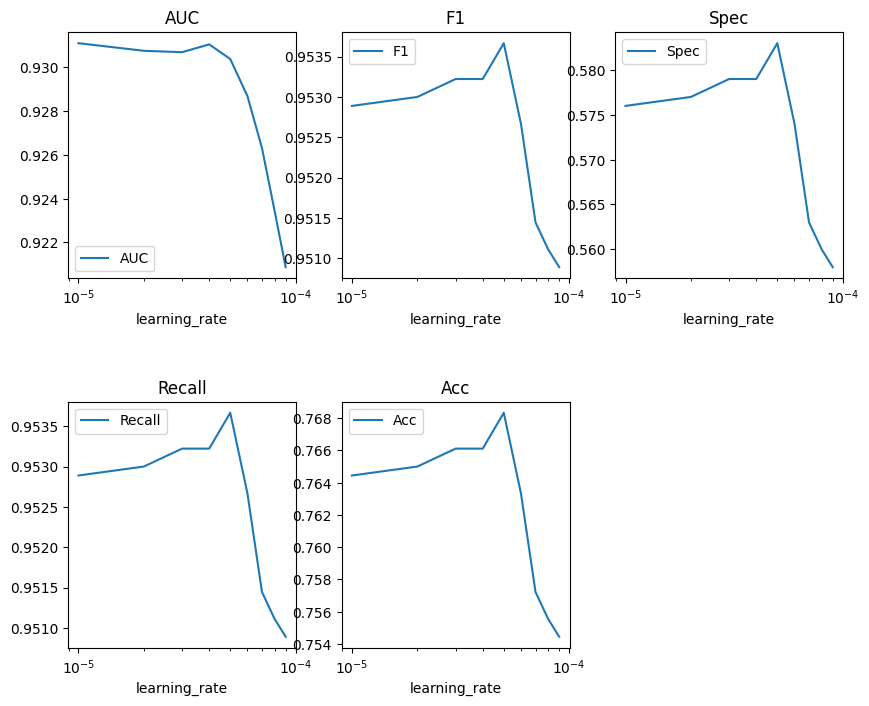

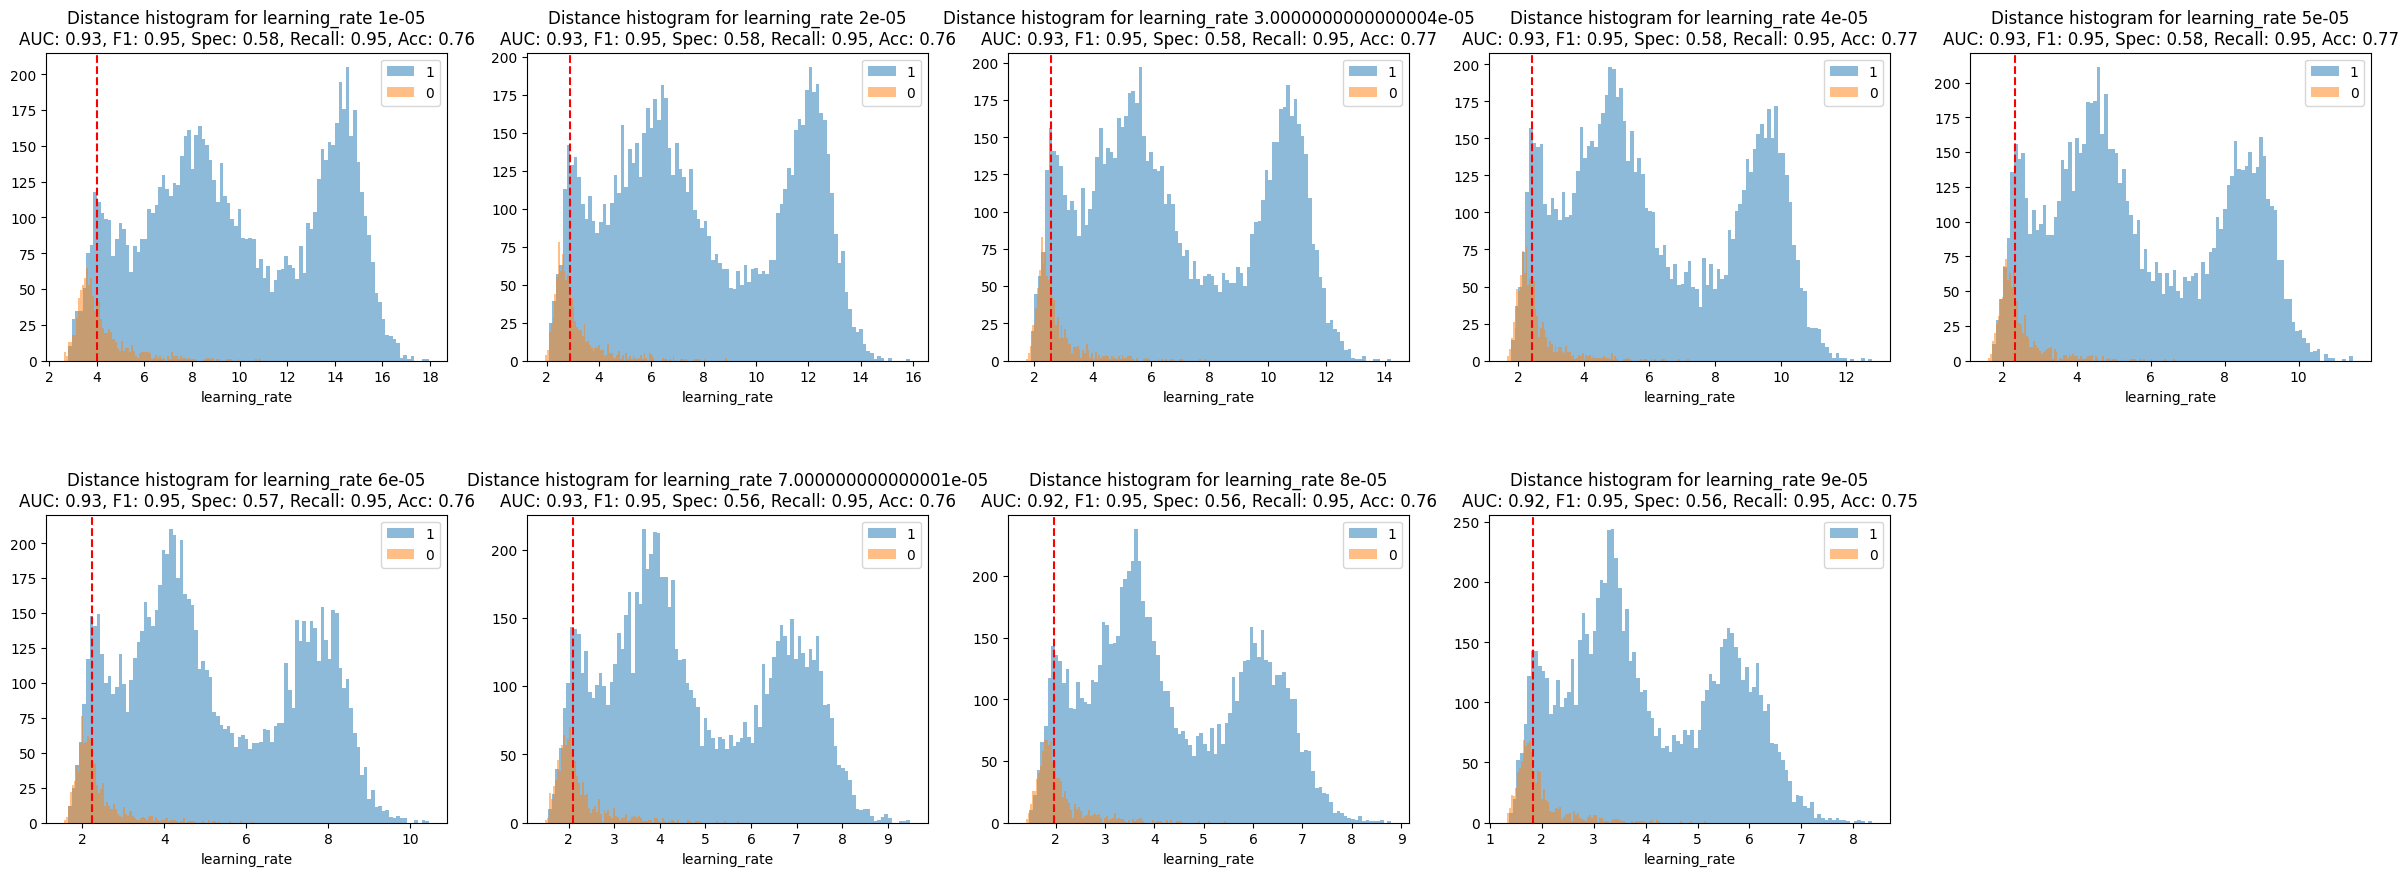

In [21]:
# Analyze result
# plot auc, f1, spec, recall, acc along learning_rate
plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2, 3, 1)
plt.semilogx(learning_rate_range, result_learning_rate['auc'], label="AUC")
plt.xlabel('learning_rate')
plt.legend()
plt.title("AUC")
plt.subplot(2, 3, 2)
plt.semilogx(learning_rate_range, result_learning_rate['f1'], label="F1")
plt.xlabel('learning_rate')
plt.legend()
plt.title("F1")
plt.subplot(2, 3, 3)
plt.semilogx(learning_rate_range, result_learning_rate['spec'], label="Spec")
plt.xlabel('learning_rate')
plt.legend()
plt.title("Spec")
plt.subplot(2, 3, 4)
plt.semilogx(learning_rate_range, result_learning_rate['recall'], label="Recall")
plt.xlabel('learning_rate')
plt.legend()  
plt.title("Recall")
plt.subplot(2, 3, 5)
plt.semilogx(learning_rate_range, result_learning_rate['acc'], label="Acc")
plt.xlabel('learning_rate')
plt.legend()
plt.title("Acc")

# plot the histogram for each learning_rate
plt.figure(figsize=(30, 10))
for i, lr in enumerate(learning_rate_range):
    plt.subplot(2, int(np.ceil(len(learning_rate_range)/2)), i+1)
    plt.subplots_adjust(hspace=0.5)
    thres = np.percentile(result_learning_rate['df'][i]["minimum_dists"], 10)
    for label in result_learning_rate['df'][i]["label"].unique():
        plt.hist(result_learning_rate['df'][i][result_learning_rate['df'][i]["label"] == label]["minimum_dists"], alpha=0.5, label=label, bins=100)
    plt.legend()
    plt.title(f"Distance histogram for learning_rate {lr}\nAUC: {result_learning_rate['auc'][i]:.2f}, F1: {result_learning_rate['f1'][i]:.2f}, Spec: {result_learning_rate['spec'][i]:.2f}, Recall: {result_learning_rate['recall'][i]:.2f}, Acc: {result_learning_rate['acc'][i]:.2f}")
    plt.axvline(x=thres, color="r", linestyle="--")
    plt.xlabel('learning_rate')

# print the best case according to the average F1 score
